In [115]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import joblib
import os
import time
import xgboost as xgb
import lightgbm as lgb
import shap

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from time import time
from statsmodels.tsa.stattools import kpss
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load the datasets
chýbajúci_zub = pd.read_csv('missing_tooth.csv')
odštiepený_zub = pd.read_csv('tooth_chipped_fault.csv')
povrchová_chyba = pd.read_csv('surface_fault.csv')
bez_poruchy = pd.read_csv('no_fault.csv')
koreňová_trhlina = pd.read_csv('root_crack.csv')
výstrednosť = pd.read_csv('eccentricity.csv')

In [116]:
chýbajúci_zub['state'] = 'chýbajúci_zub'
odštiepený_zub['state'] = 'odštiepený_zub'
povrchová_chyba['state'] = 'povrchová_chyba'
bez_poruchy['state'] = 'bez_poruchy'
koreňová_trhlina['state'] = 'koreňová_trhlina'
výstrednosť['state'] = 'výstrednosť'

df = pd.concat([
    bez_poruchy,
    chýbajúci_zub, 
    odštiepený_zub,
    povrchová_chyba,
    koreňová_trhlina, 
    výstrednosť
])

#Normalize time_x grouped by state, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['state', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())


In [117]:
df['formated_time'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [118]:
# Define the variables before using them
speedload_8_0 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 0)].copy()
speedload_8_80 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 80)].copy()
speedload_25_0 = df[(df['speedSet'] == 25) & (df['load_value'] == 0)].copy()
speedload_25_80 = df[(df['speedSet'] == 25) & (df['load_value'] == 80)].copy()
speedload_40_0 = df[(df['speedSet'] == 40) & (df['load_value'] == 0)].copy()
speedload_40_80 = df[(df['speedSet'] == 40) & (df['load_value'] == 80)].copy()


In [119]:
# Apply the KPSS test to each unique state for 'sensor1' values by 'normalized_time'.
def apply_kpss(series):
    kpss_stat, p_value, lags, crit = kpss(series, 'c')
    return kpss_stat, p_value, crit

# Apply the KPSS test to all unique states
unique_states = speedload_8_0['state'].unique()
kpss_results = {}
for state in unique_states:
    # Extracting the time series data for 'sensor1' for the current state
    time_series = speedload_8_0.loc[speedload_8_0['state'] == state, 'sensor1']
    # Applying KPSS test
    kpss_stat, p_value, crit = apply_kpss(time_series)
    kpss_results[state] = (kpss_stat, p_value, crit)

# You can print out the results or convert it to a DataFrame
kpss_results_df = pd.DataFrame(kpss_results, index=['KPSS Štatistica', 'p-hodnota', 'Kritické hodnoty']).T
print(kpss_results_df)

                 KPSS Štatistica p-hodnota  \
bez_poruchy             2.016985      0.01   
chýbajúci_zub           0.098826       0.1   
odštiepený_zub          3.135916      0.01   
povrchová_chyba         0.374733  0.088046   
koreňová_trhlina        9.098141      0.01   
výstrednosť             1.742396      0.01   

                                                   Kritické hodnoty  
bez_poruchy       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
chýbajúci_zub     {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
odštiepený_zub    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
povrchová_chyba   {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
koreňová_trhlina  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
výstrednosť       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  


C:\Users\rober\AppData\Local\Temp\ipykernel_13620\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_13620\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_13620\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_13620\36392788.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_13620\36392788.py:3: Interpo

<Figure size 640x480 with 0 Axes>

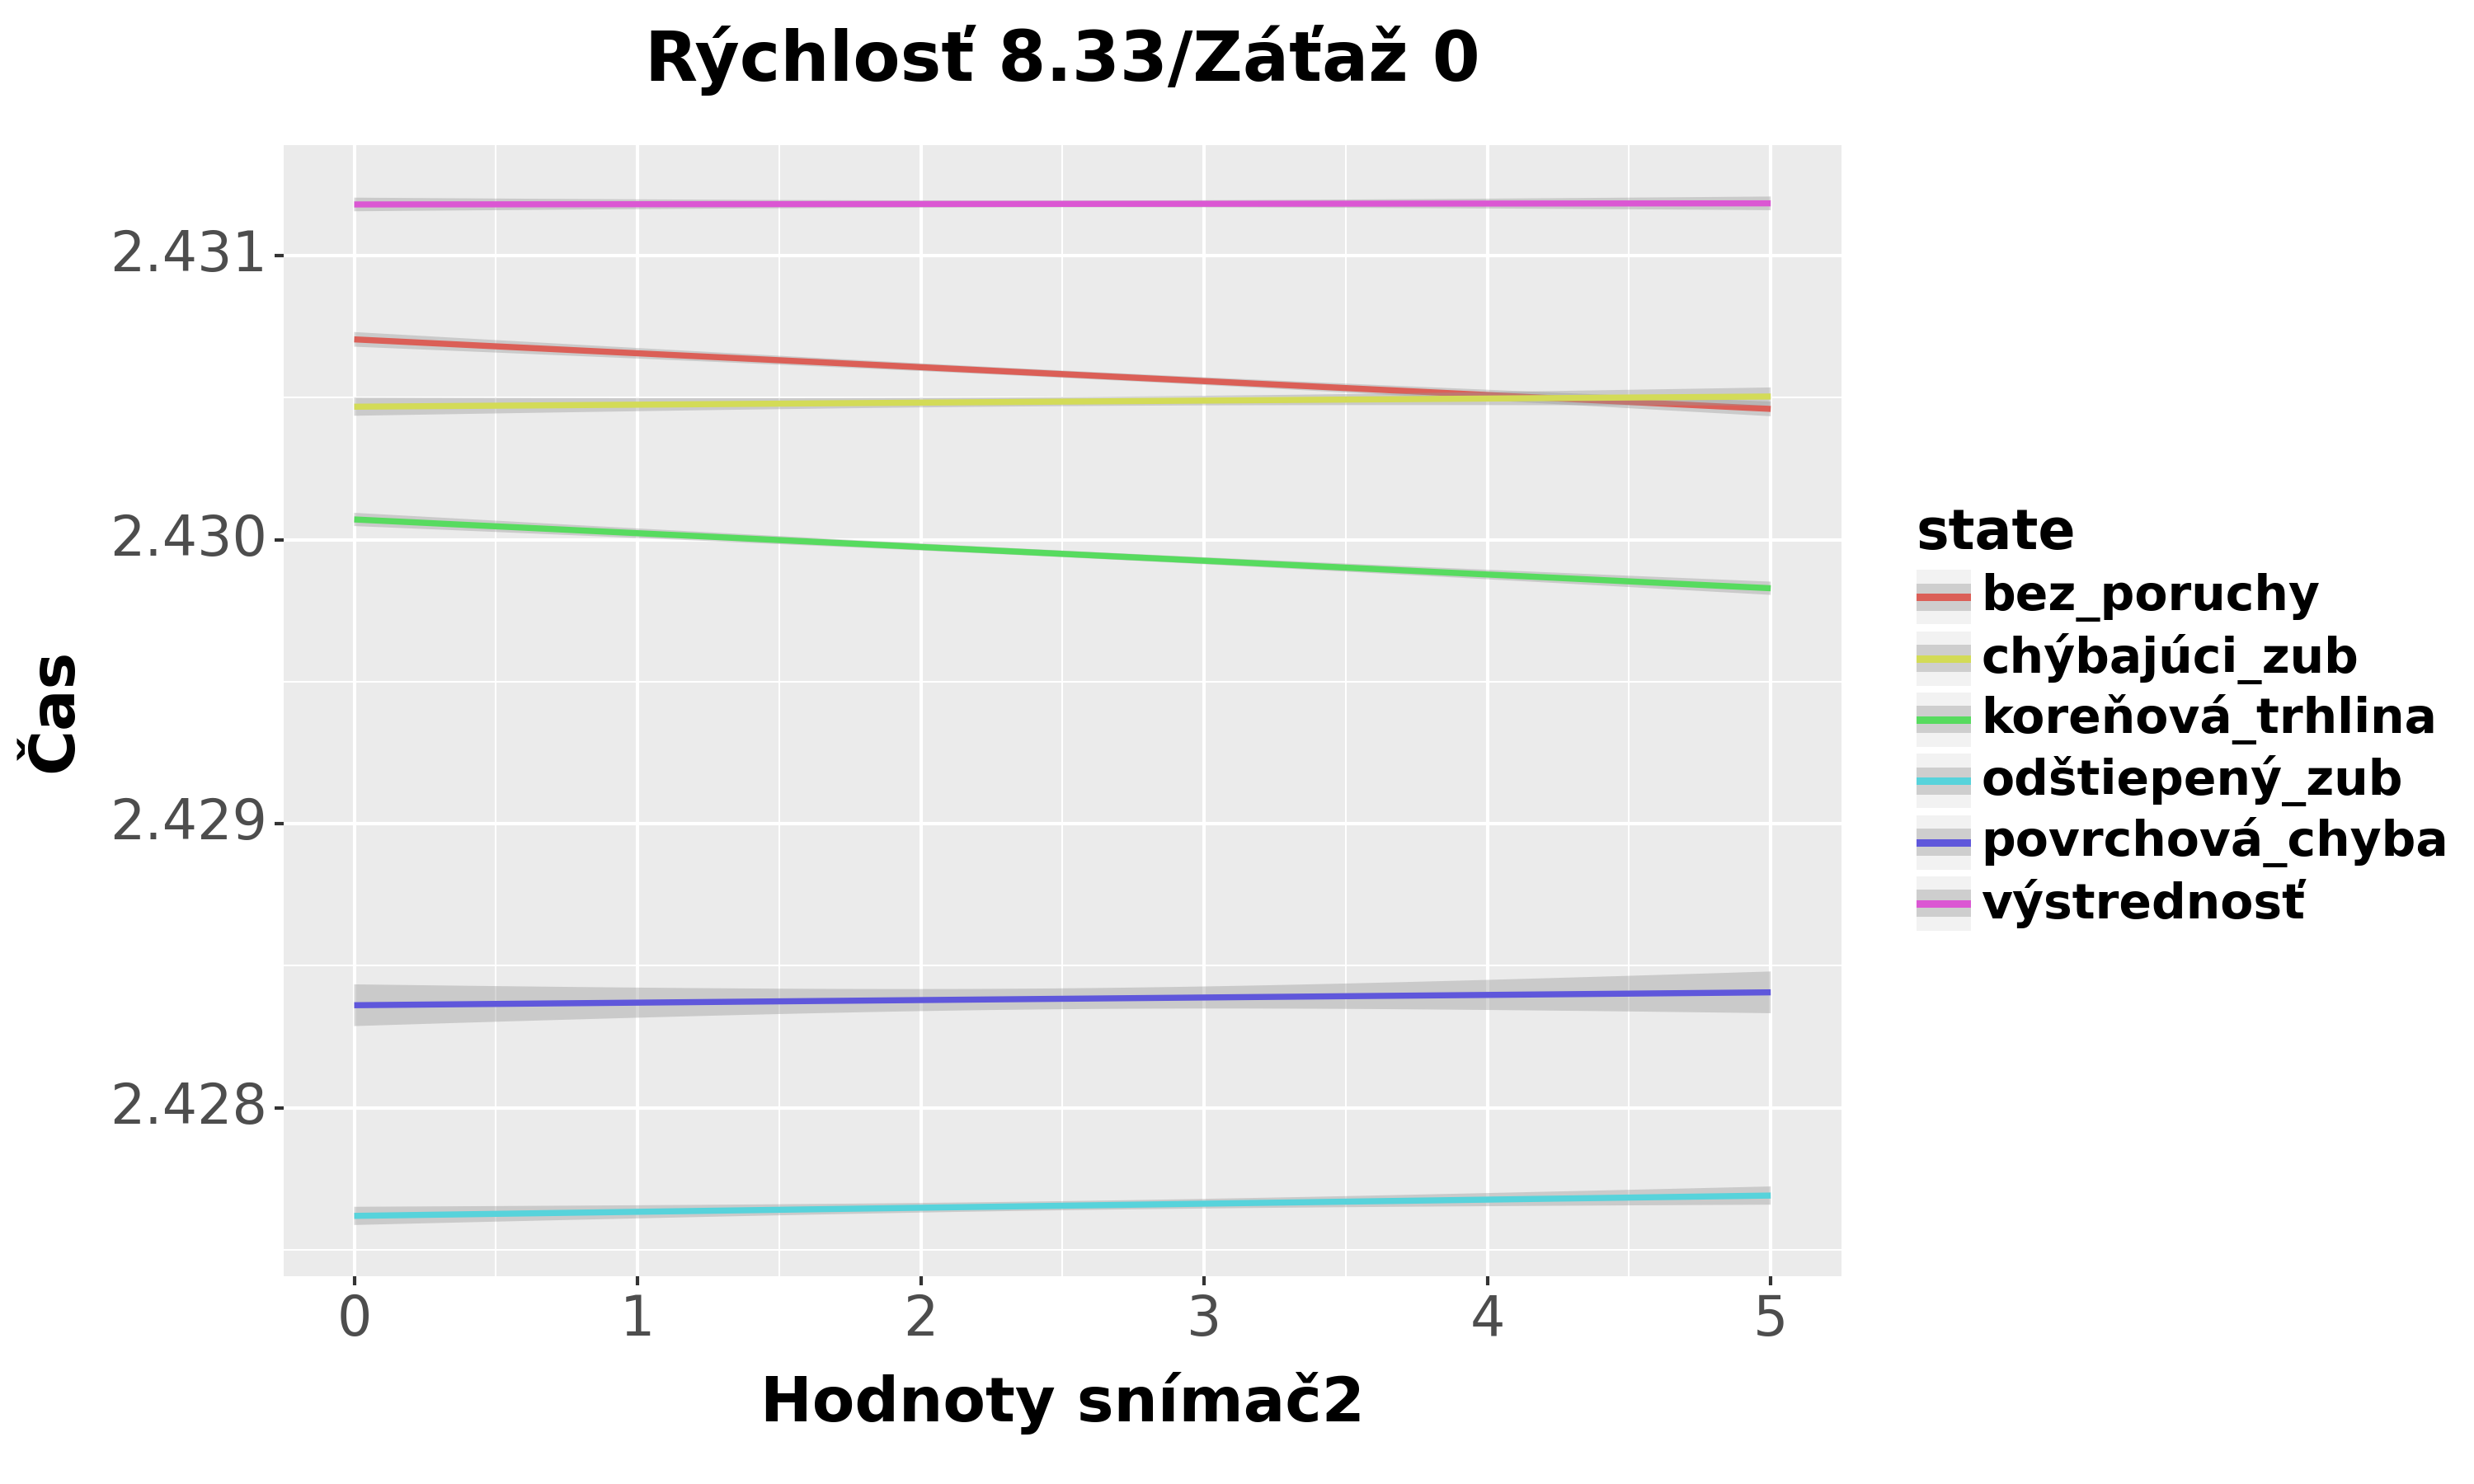

<Figure Size: (1500 x 900)>

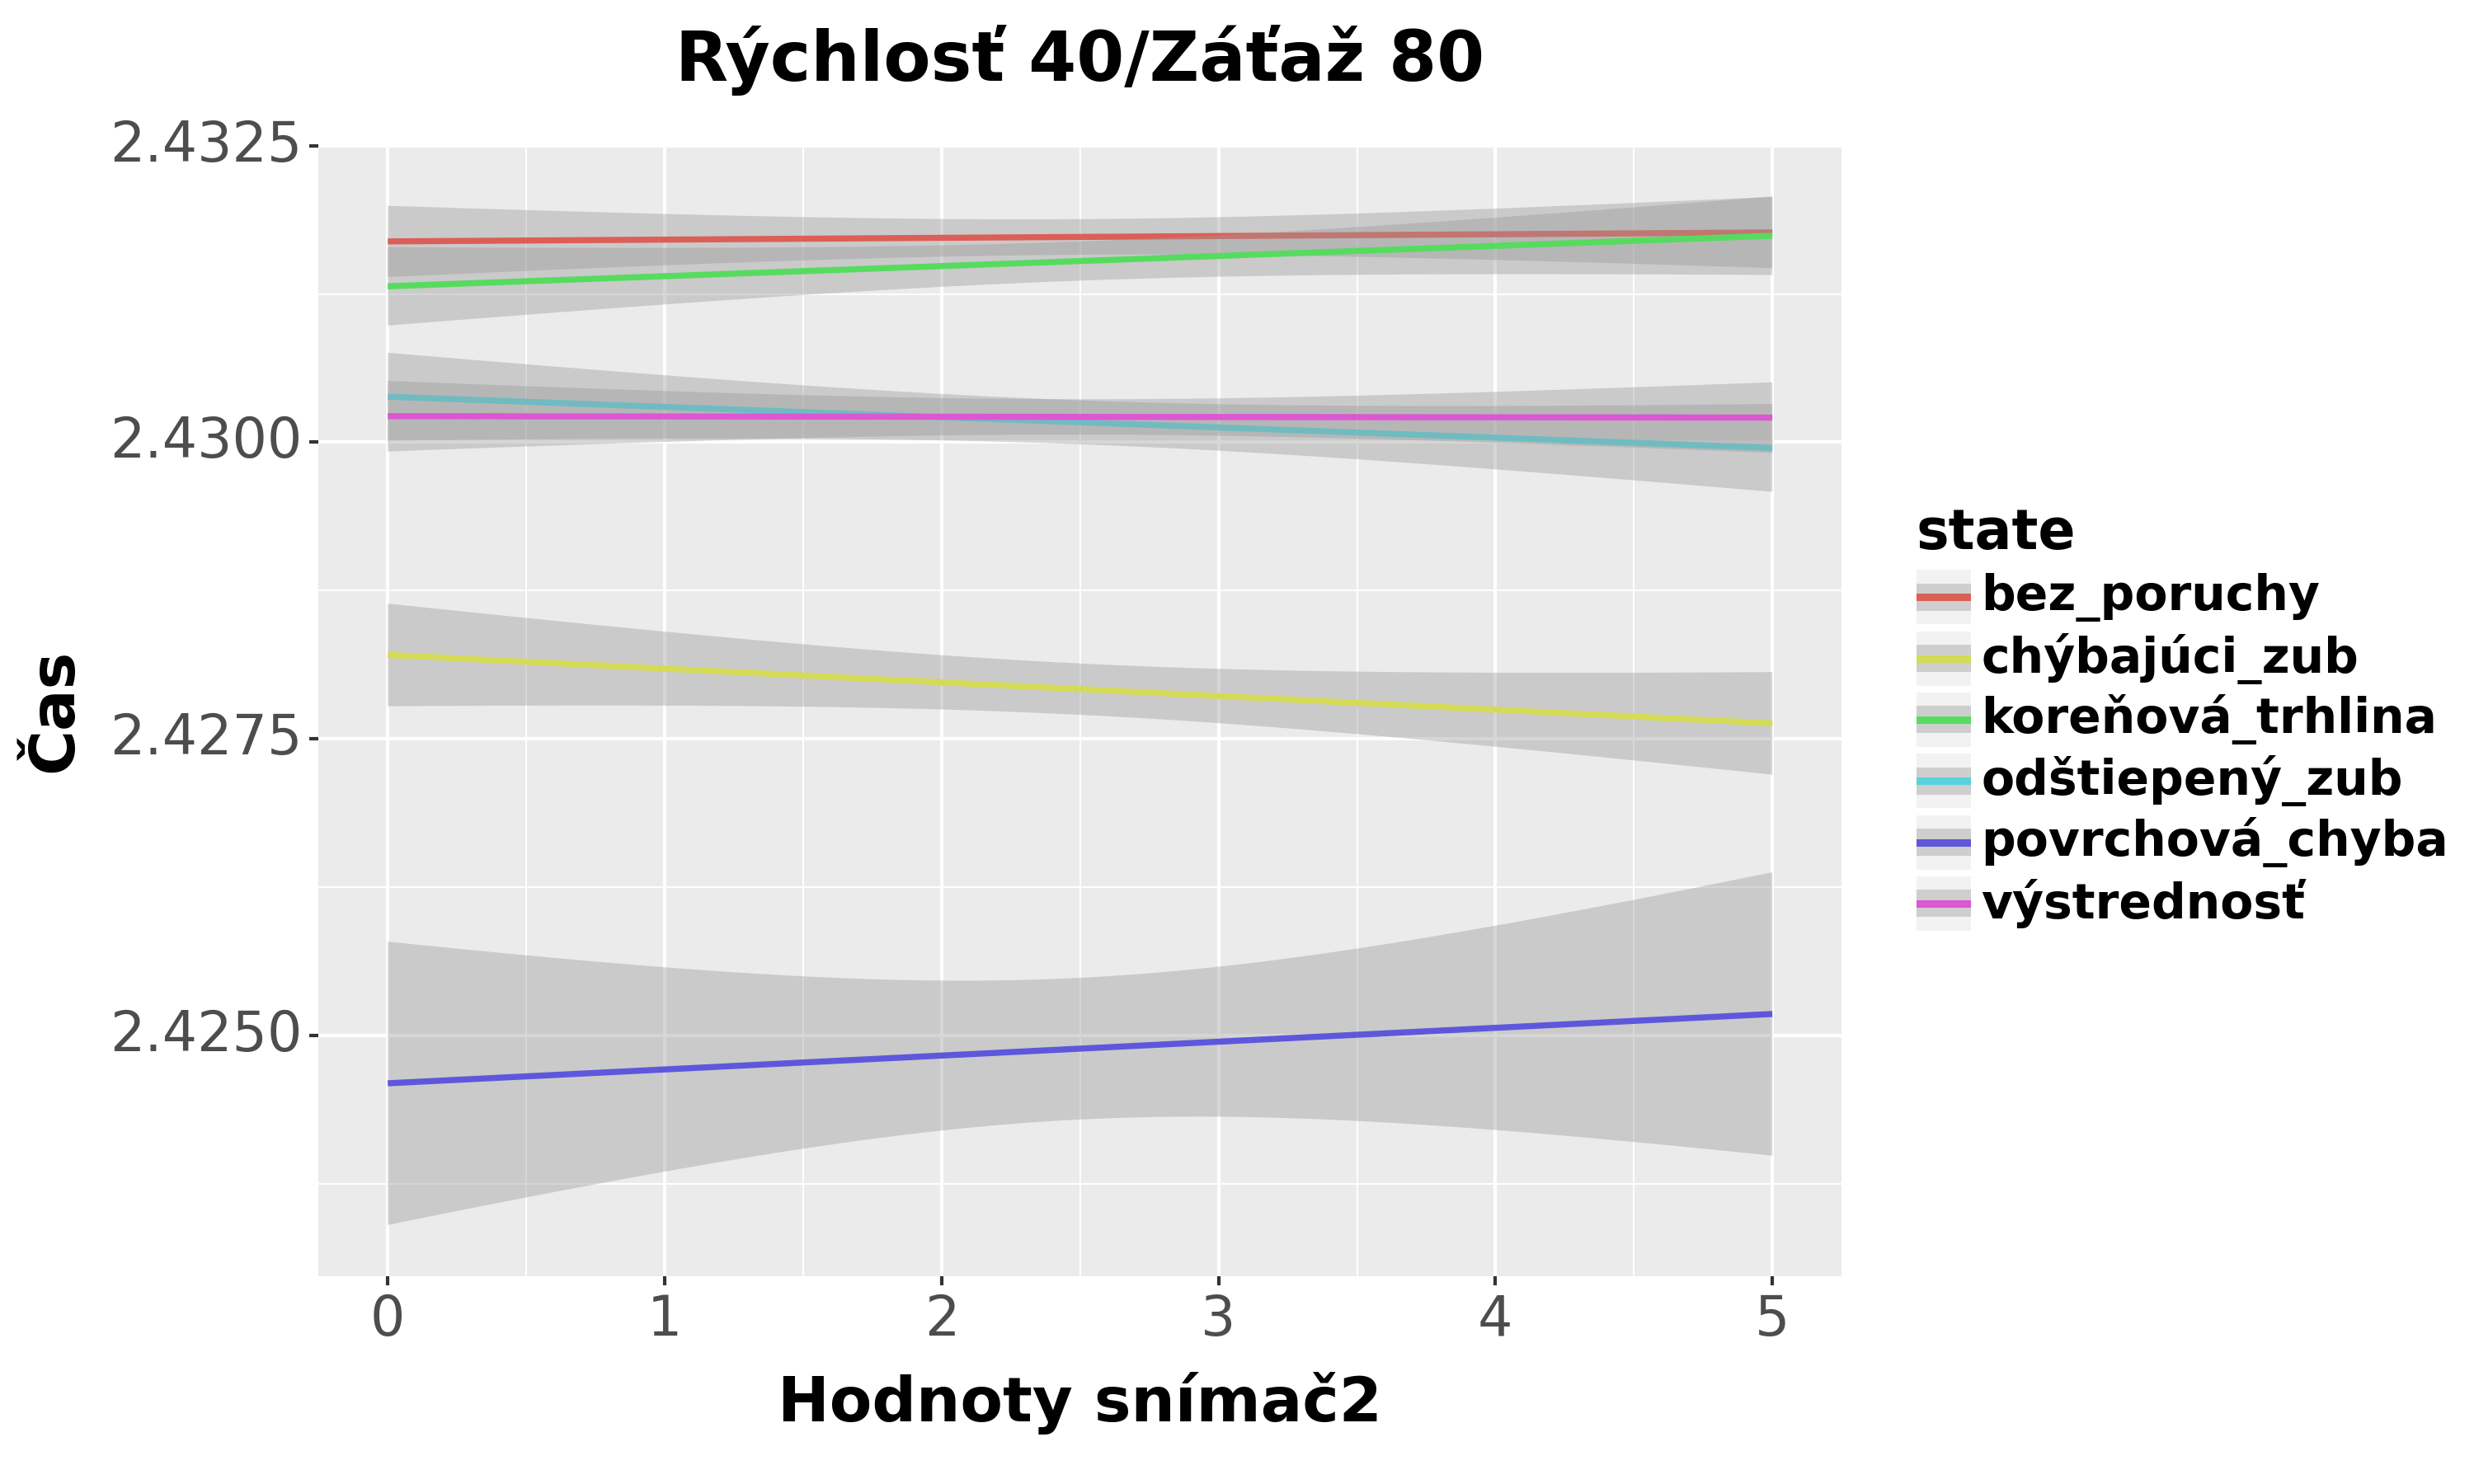

<Figure Size: (1500 x 900)>

In [120]:
display(ggplot(data=speedload_8_0, mapping=aes(x='time_normalized', y='sensor2', color='state')) + geom_smooth() + 
        ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Hodnoty snímač2', y='Čas', fill='Stav') +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_80, mapping=aes(x='time_normalized', y='sensor2', color='state')) + geom_smooth() + 
        ggtitle('Rýchlosť 40/Záťaž 80') +
        labs(x='Hodnoty snímač2', y='Čas', fill='Stav') +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))


c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 2915 rows containing non-finite values.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 2915 rows containing non-finite values.


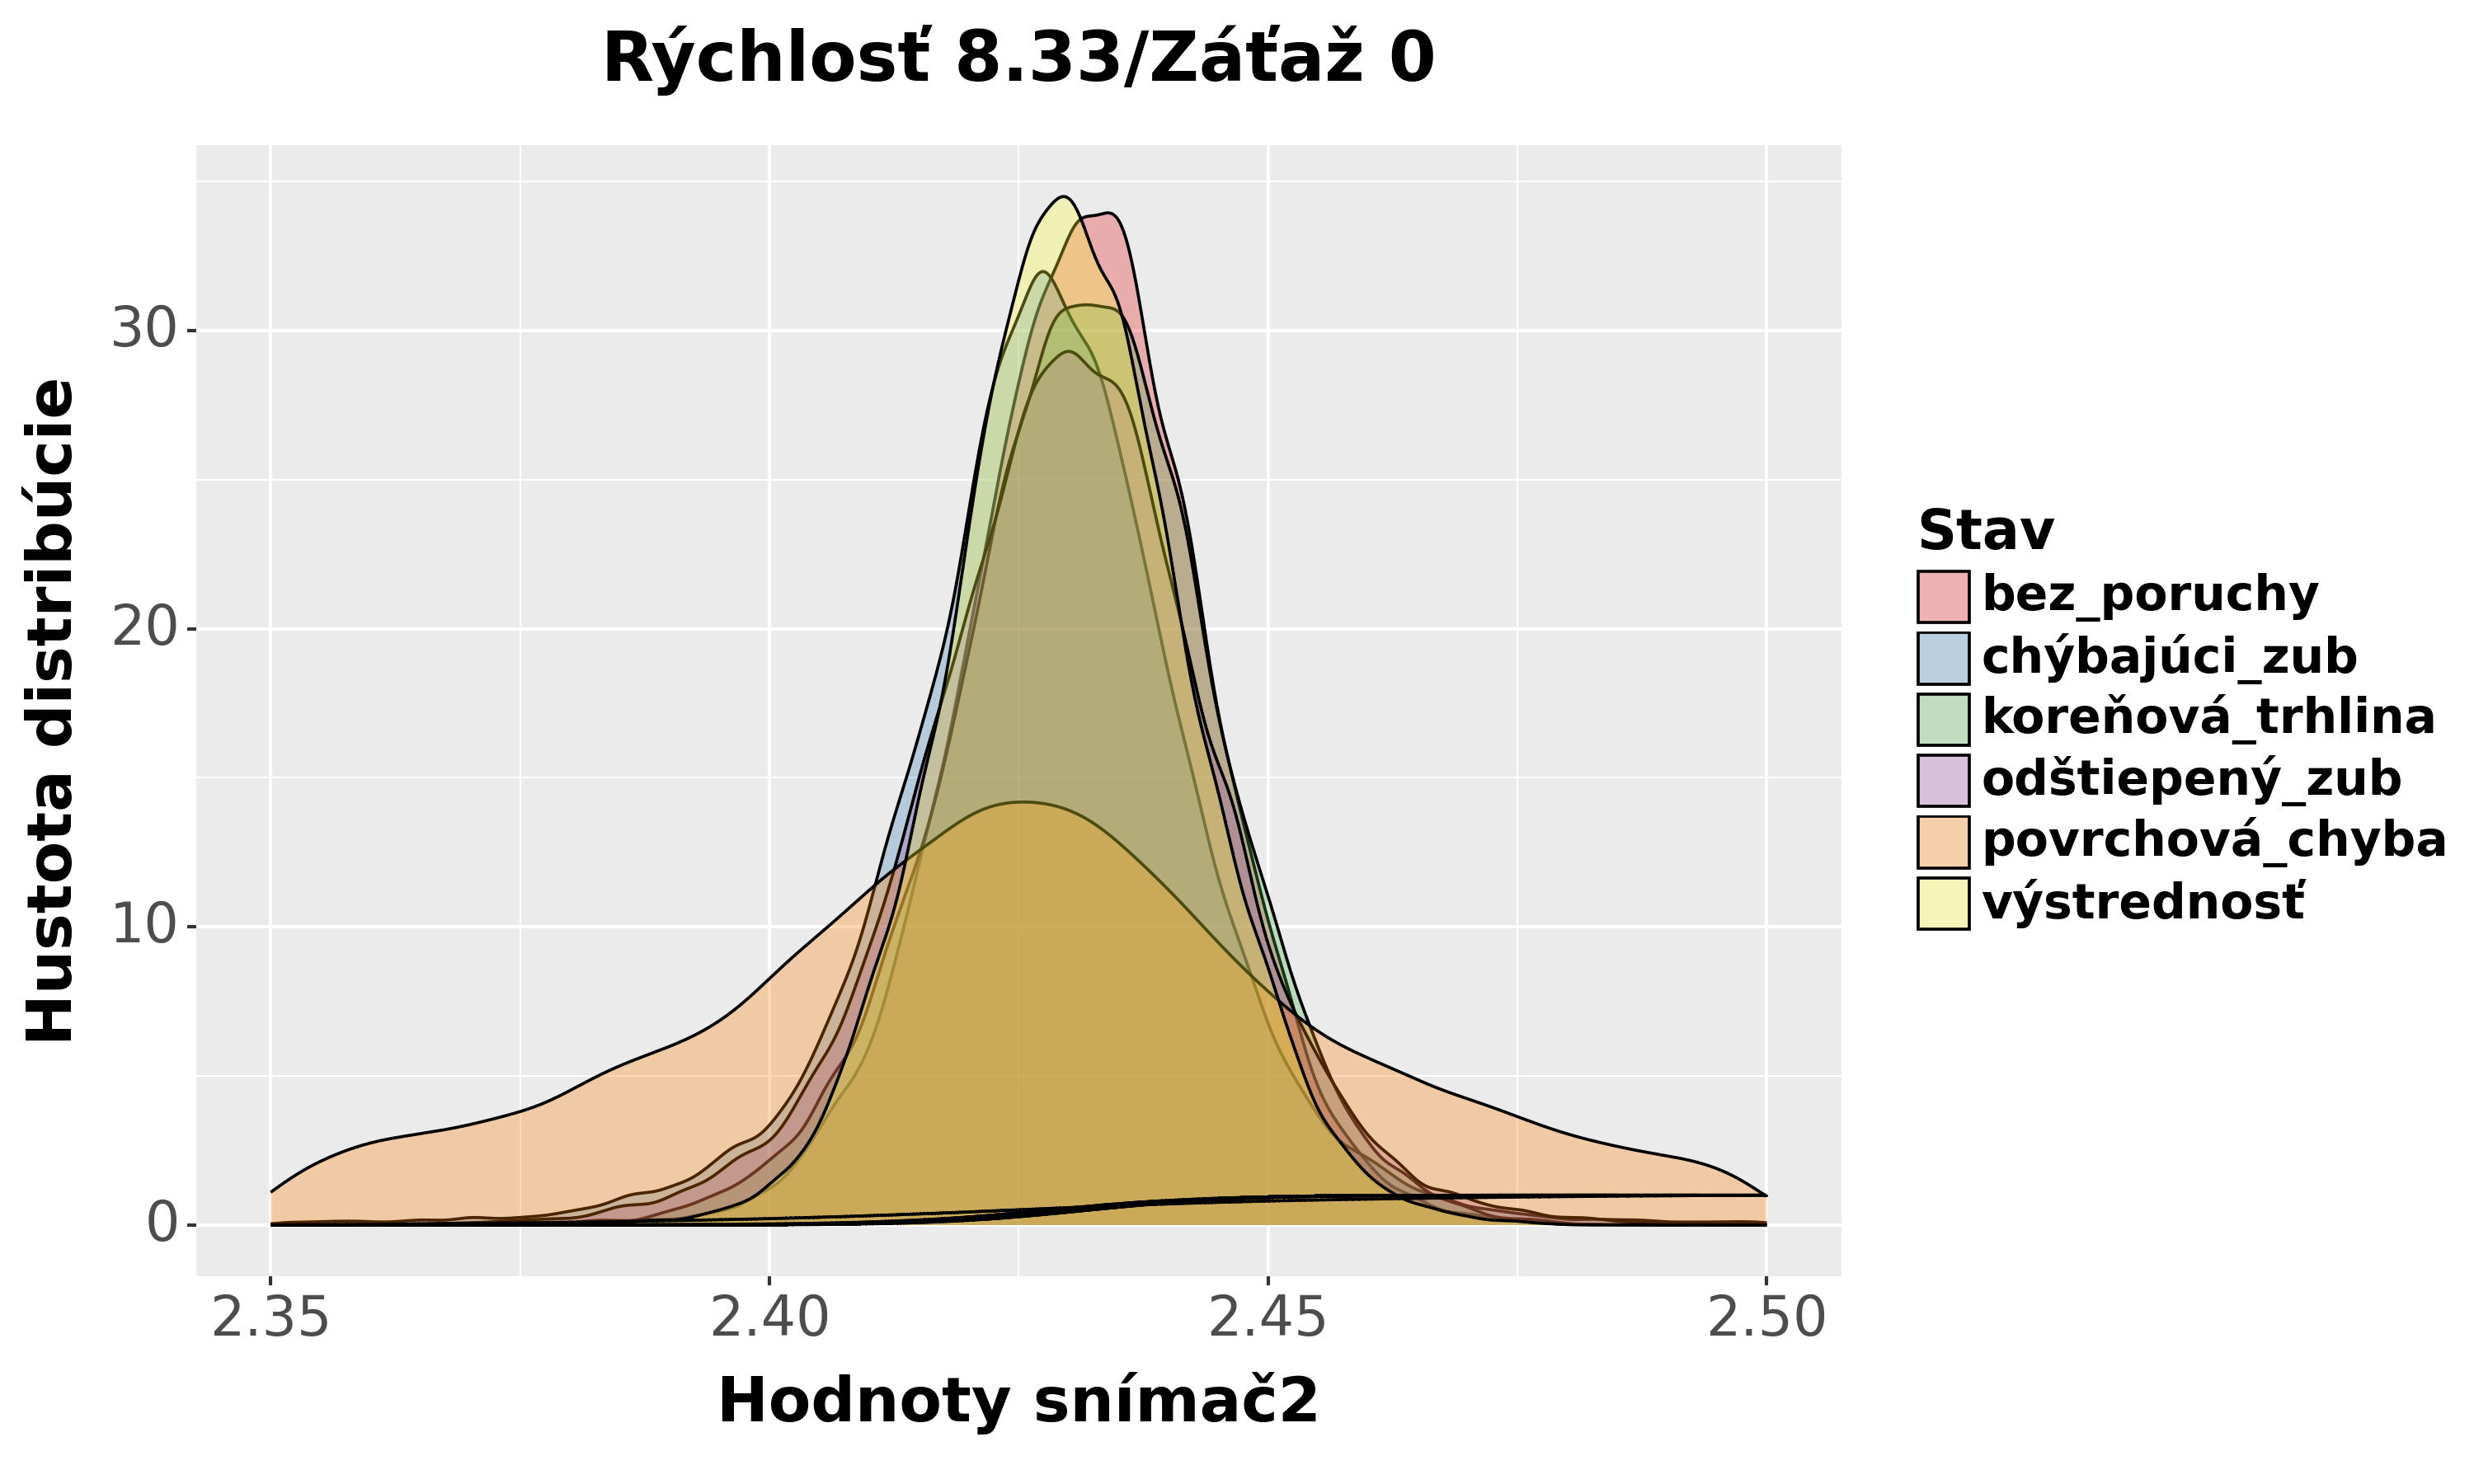

<Figure Size: (1500 x 900)>

c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 732 rows containing non-finite values.
c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 732 rows containing non-finite values.


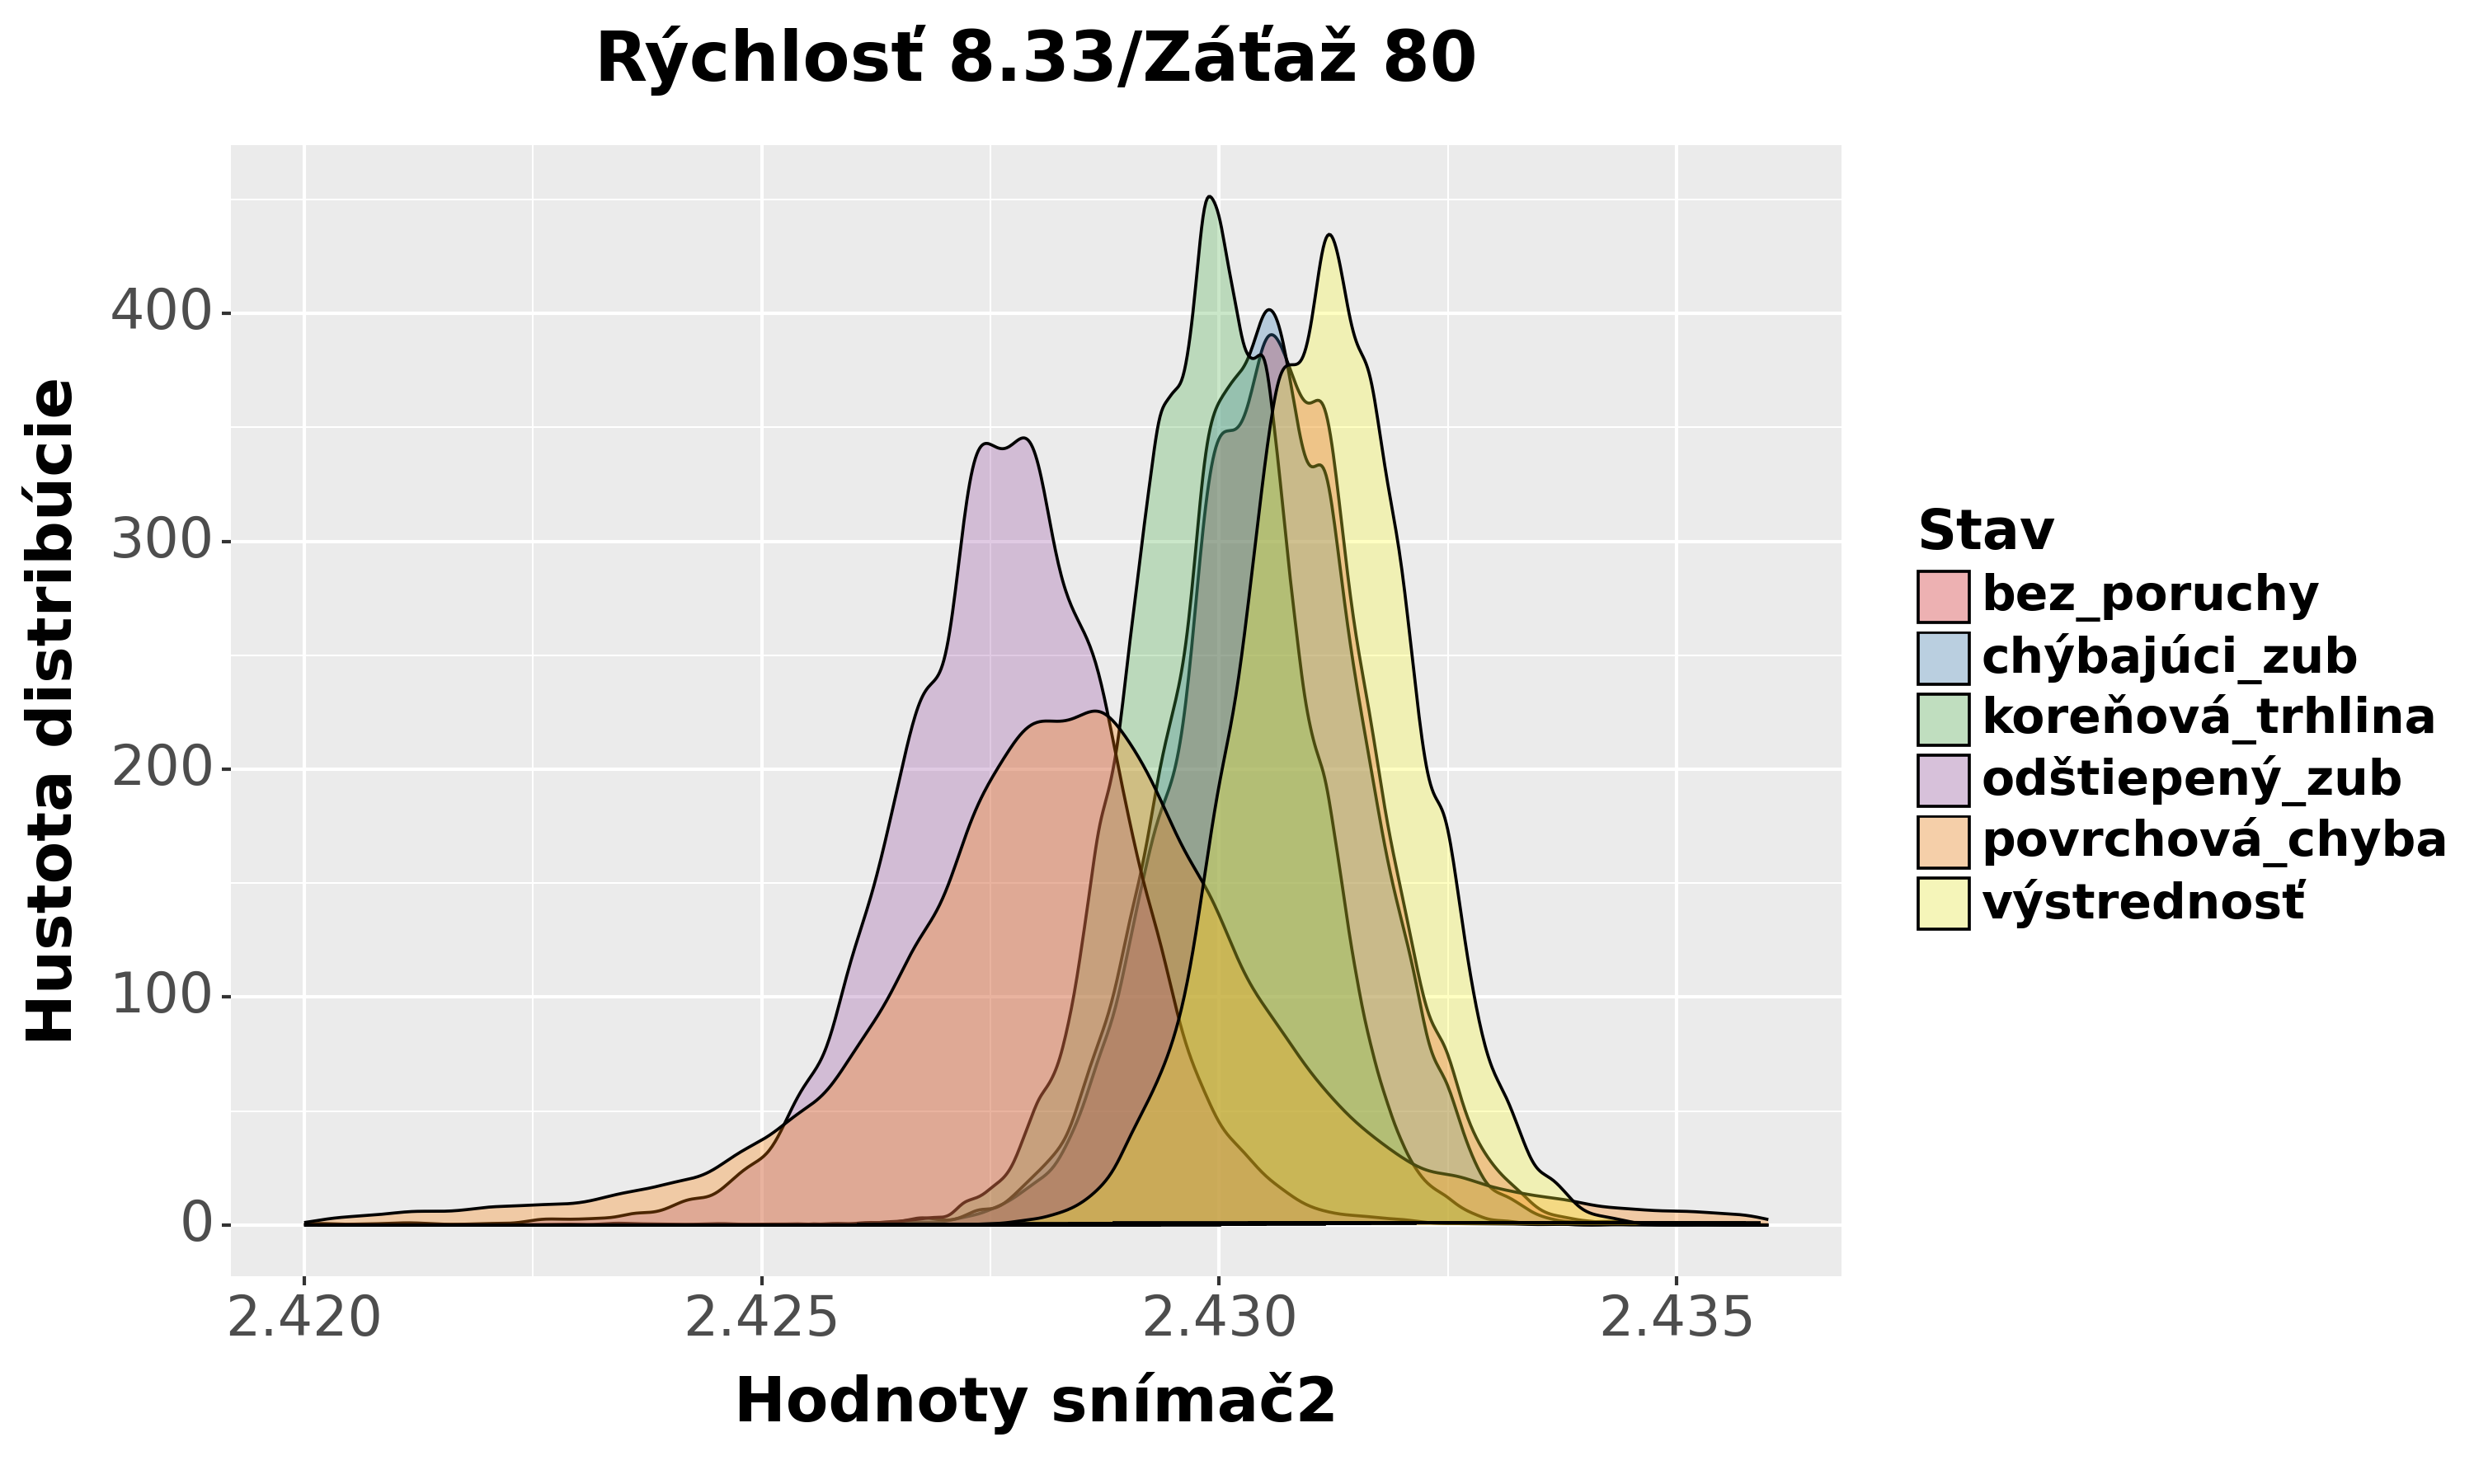

<Figure Size: (1500 x 900)>

In [121]:
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

display(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Hodnoty snímač2', y='Hustota distribúcie', fill='Stav') + xlim(2.35, 2.5) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='state')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 80') +
        labs(x='Hodnoty snímač2', y='Hustota distribúcie', fill='Stav') + xlim(2.42, 2.436) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))

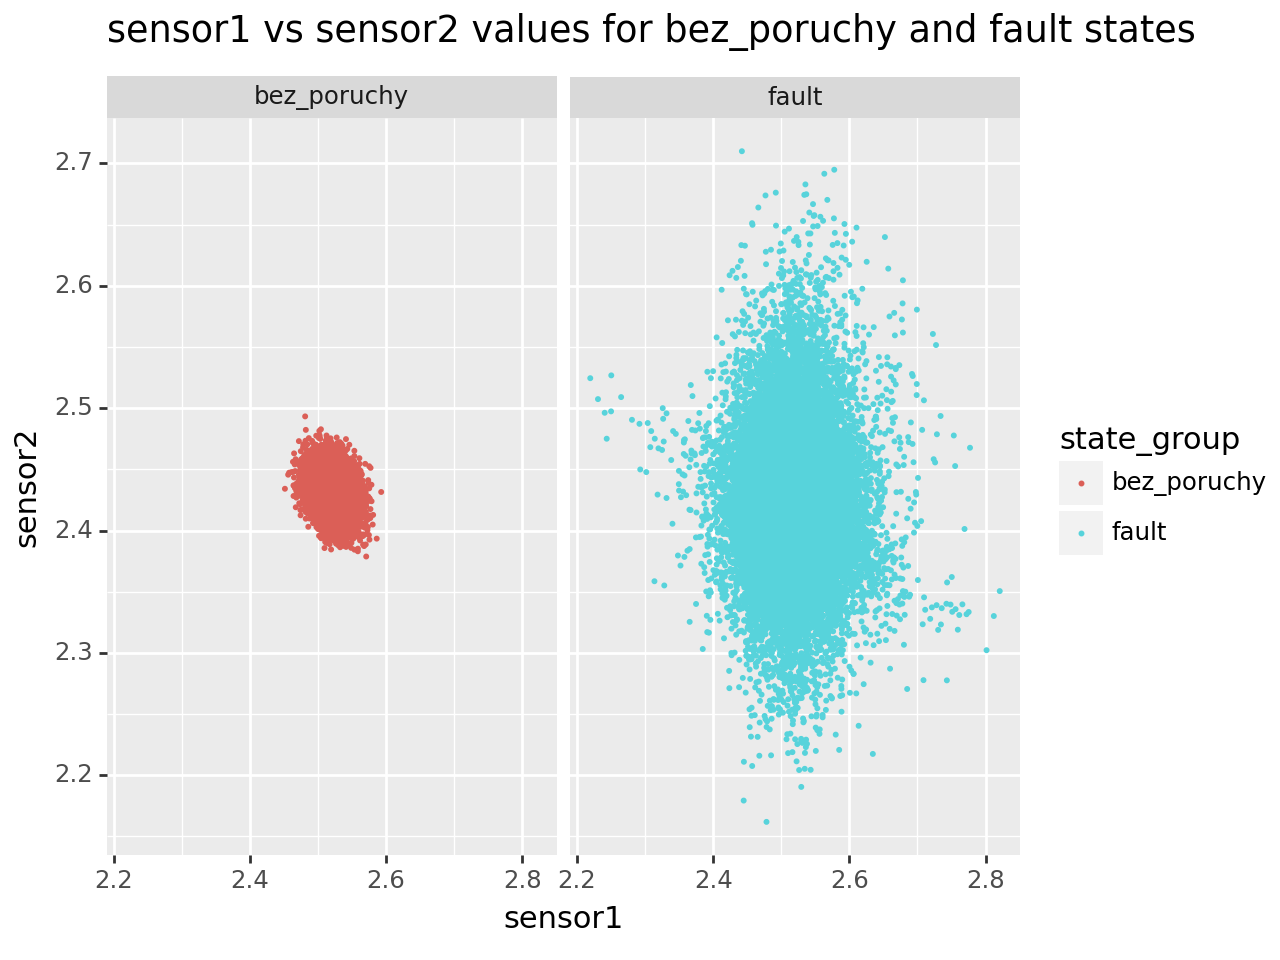

<Figure Size: (640 x 480)>

In [122]:
# Plot state column sensor values as bez_poruchy against other '~bez_poruchy' values
df_news = df.copy()
df_news['state_group'] = df_news['state'].apply(lambda x: 'bez_poruchy' if x == 'bez_poruchy' else 'fault')
display(ggplot(df_news, aes(x='sensor1', y='sensor2', color='state_group')) + geom_point(size=0.2) + facet_wrap('~state_group') + ggtitle('sensor1 vs sensor2 values for bez_poruchy and fault states'))


In [123]:
# Example data setup (replace or adjust based on your actual dataframe 'df')
df['state_expected'] = df.state.apply(lambda x: ['bez_poruchy', 'chýbajúci_zub', 'odštiepený_zub', 'povrchová_chyba', 'koreňová_trhlina', 'výstrednosť'].index(x))

# Creating a dictionary for the transformation
mapping_dict = df.set_index('state_expected')['state'].to_dict()

# Correctly creating DataFrame from dictionary
state_expected_keys = pd.DataFrame(list(mapping_dict.items()), columns=['state_expected', 'state'])
display(state_expected_keys)
# Creating a new DataFrame without certain columns
df_edit = df[['sensor1', 'sensor2', 'speedSet', 'load_value', 'state_expected', 'time_normalized']].copy()

,state_expected,state
0,0,bez_poruchy
1,1,chýbajúci_zub
2,2,odštiepený_zub
3,3,povrchová_chyba
4,4,koreňová_trhlina
5,5,výstrednosť


In [124]:
# X_train would be df_edit values where time_normalized is less than 4
X_train = df_edit[df_edit['time_normalized'] < 4].copy()

In [125]:
X_train['sensor1_25_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_train['sensor2_25_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_train['sensor1_25_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_train['sensor2_25_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_train['sensor1_25_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_train['sensor2_25_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_train['sensor1_25_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_train['sensor2_25_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_train['sensor1_25_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).median())
X_train['sensor2_25_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).median())

X_train['sensor1_50_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_train['sensor2_50_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_train['sensor1_50_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_train['sensor2_50_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_train['sensor1_50_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_train['sensor2_50_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_train['sensor1_50_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_train['sensor2_50_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_train['sensor1_50_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).median())
X_train['sensor2_50_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).median())

X_train['sensor1_100_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_train['sensor2_100_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_train['sensor1_100_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_train['sensor2_100_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_train['sensor1_100_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_train['sensor2_100_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_train['sensor1_100_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_train['sensor2_100_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_train['sensor1_100_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).median())
X_train['sensor2_100_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).median())

X_train['sensor1_200_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_train['sensor2_200_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_train['sensor1_200_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_train['sensor2_200_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_train['sensor1_200_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_train['sensor2_200_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_train['sensor1_200_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_train['sensor2_200_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_train['sensor1_200_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).median())
X_train['sensor2_200_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).median())

X_train['sensor1_400_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_train['sensor2_400_max'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_train['sensor1_400_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_train['sensor2_400_min'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_train['sensor1_400_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_train['sensor2_400_mean'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_train['sensor1_400_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_train['sensor2_400_std'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_train['sensor1_400_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).median())
X_train['sensor2_400_median'] = X_train.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).median())


In [126]:
X_test = df_edit[df_edit['time_normalized'] >= 4].copy()

In [127]:
X_test['sensor1_25_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_test['sensor2_25_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
X_test['sensor1_25_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_test['sensor2_25_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
X_test['sensor1_25_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_test['sensor2_25_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
X_test['sensor1_25_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_test['sensor2_25_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
X_test['sensor1_25_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).median())
X_test['sensor2_25_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).median())

X_test['sensor1_50_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_test['sensor2_50_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
X_test['sensor1_50_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_test['sensor2_50_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
X_test['sensor1_50_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_test['sensor2_50_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
X_test['sensor1_50_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_test['sensor2_50_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
X_test['sensor1_50_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).median())
X_test['sensor2_50_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).median())

X_test['sensor1_100_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_test['sensor2_100_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
X_test['sensor1_100_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_test['sensor2_100_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
X_test['sensor1_100_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_test['sensor2_100_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
X_test['sensor1_100_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_test['sensor2_100_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
X_test['sensor1_100_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).median())
X_test['sensor2_100_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).median())

X_test['sensor1_200_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_test['sensor2_200_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
X_test['sensor1_200_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_test['sensor2_200_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
X_test['sensor1_200_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_test['sensor2_200_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
X_test['sensor1_200_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_test['sensor2_200_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
X_test['sensor1_200_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).median())
X_test['sensor2_200_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).median())

X_test['sensor1_400_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_test['sensor2_400_max'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
X_test['sensor1_400_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_test['sensor2_400_min'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
X_test['sensor1_400_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_test['sensor2_400_mean'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
X_test['sensor1_400_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_test['sensor2_400_std'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
X_test['sensor1_400_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).median())
X_test['sensor2_400_median'] = X_test.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).median())


In [128]:
y_train = X_train['state_expected']
y_test = X_test['state_expected']

# keep not standardized data in X_train_not_scaled, X_test_not_scaled, X_val_not_scaled
X_train_not_scaled = X_train.copy()
X_test_not_scaled = X_test.copy()

# Drop column state_expected
X_train.drop(columns='state_expected', inplace=True)
X_test.drop(columns='state_expected', inplace=True)

X_train = X_train.drop(columns=['time_normalized'])
X_test = X_test.drop(columns=['time_normalized'])

# Solve NaN values
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=100, multi_class='ovr', C=0.1)
log_reg.fit(X_train, y_train)
start_time1 = time()
y_pred = log_reg.predict(X_test)
training_time = time() - start_time1

accuracy_lr = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lr)

# Save the model to a file
model_name = f'logistic_regression_{accuracy_lr:.4f}'

# Save the model
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
os.makedirs(model_directory, exist_ok=True)
joblib.dump(log_reg, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lr}\n")
    f.write(f"Training Time: {training_time} seconds\n")
    f.write(f"Hyperparameters: {log_reg.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")

c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 0.6955166666666667
Model and metadata saved in models


In [79]:
# Compare X_train and X_train_not_scaled shapes
print(X_train.shape)
print(X_train_not_scaled.shape)

(720000, 54)
(720000, 56)


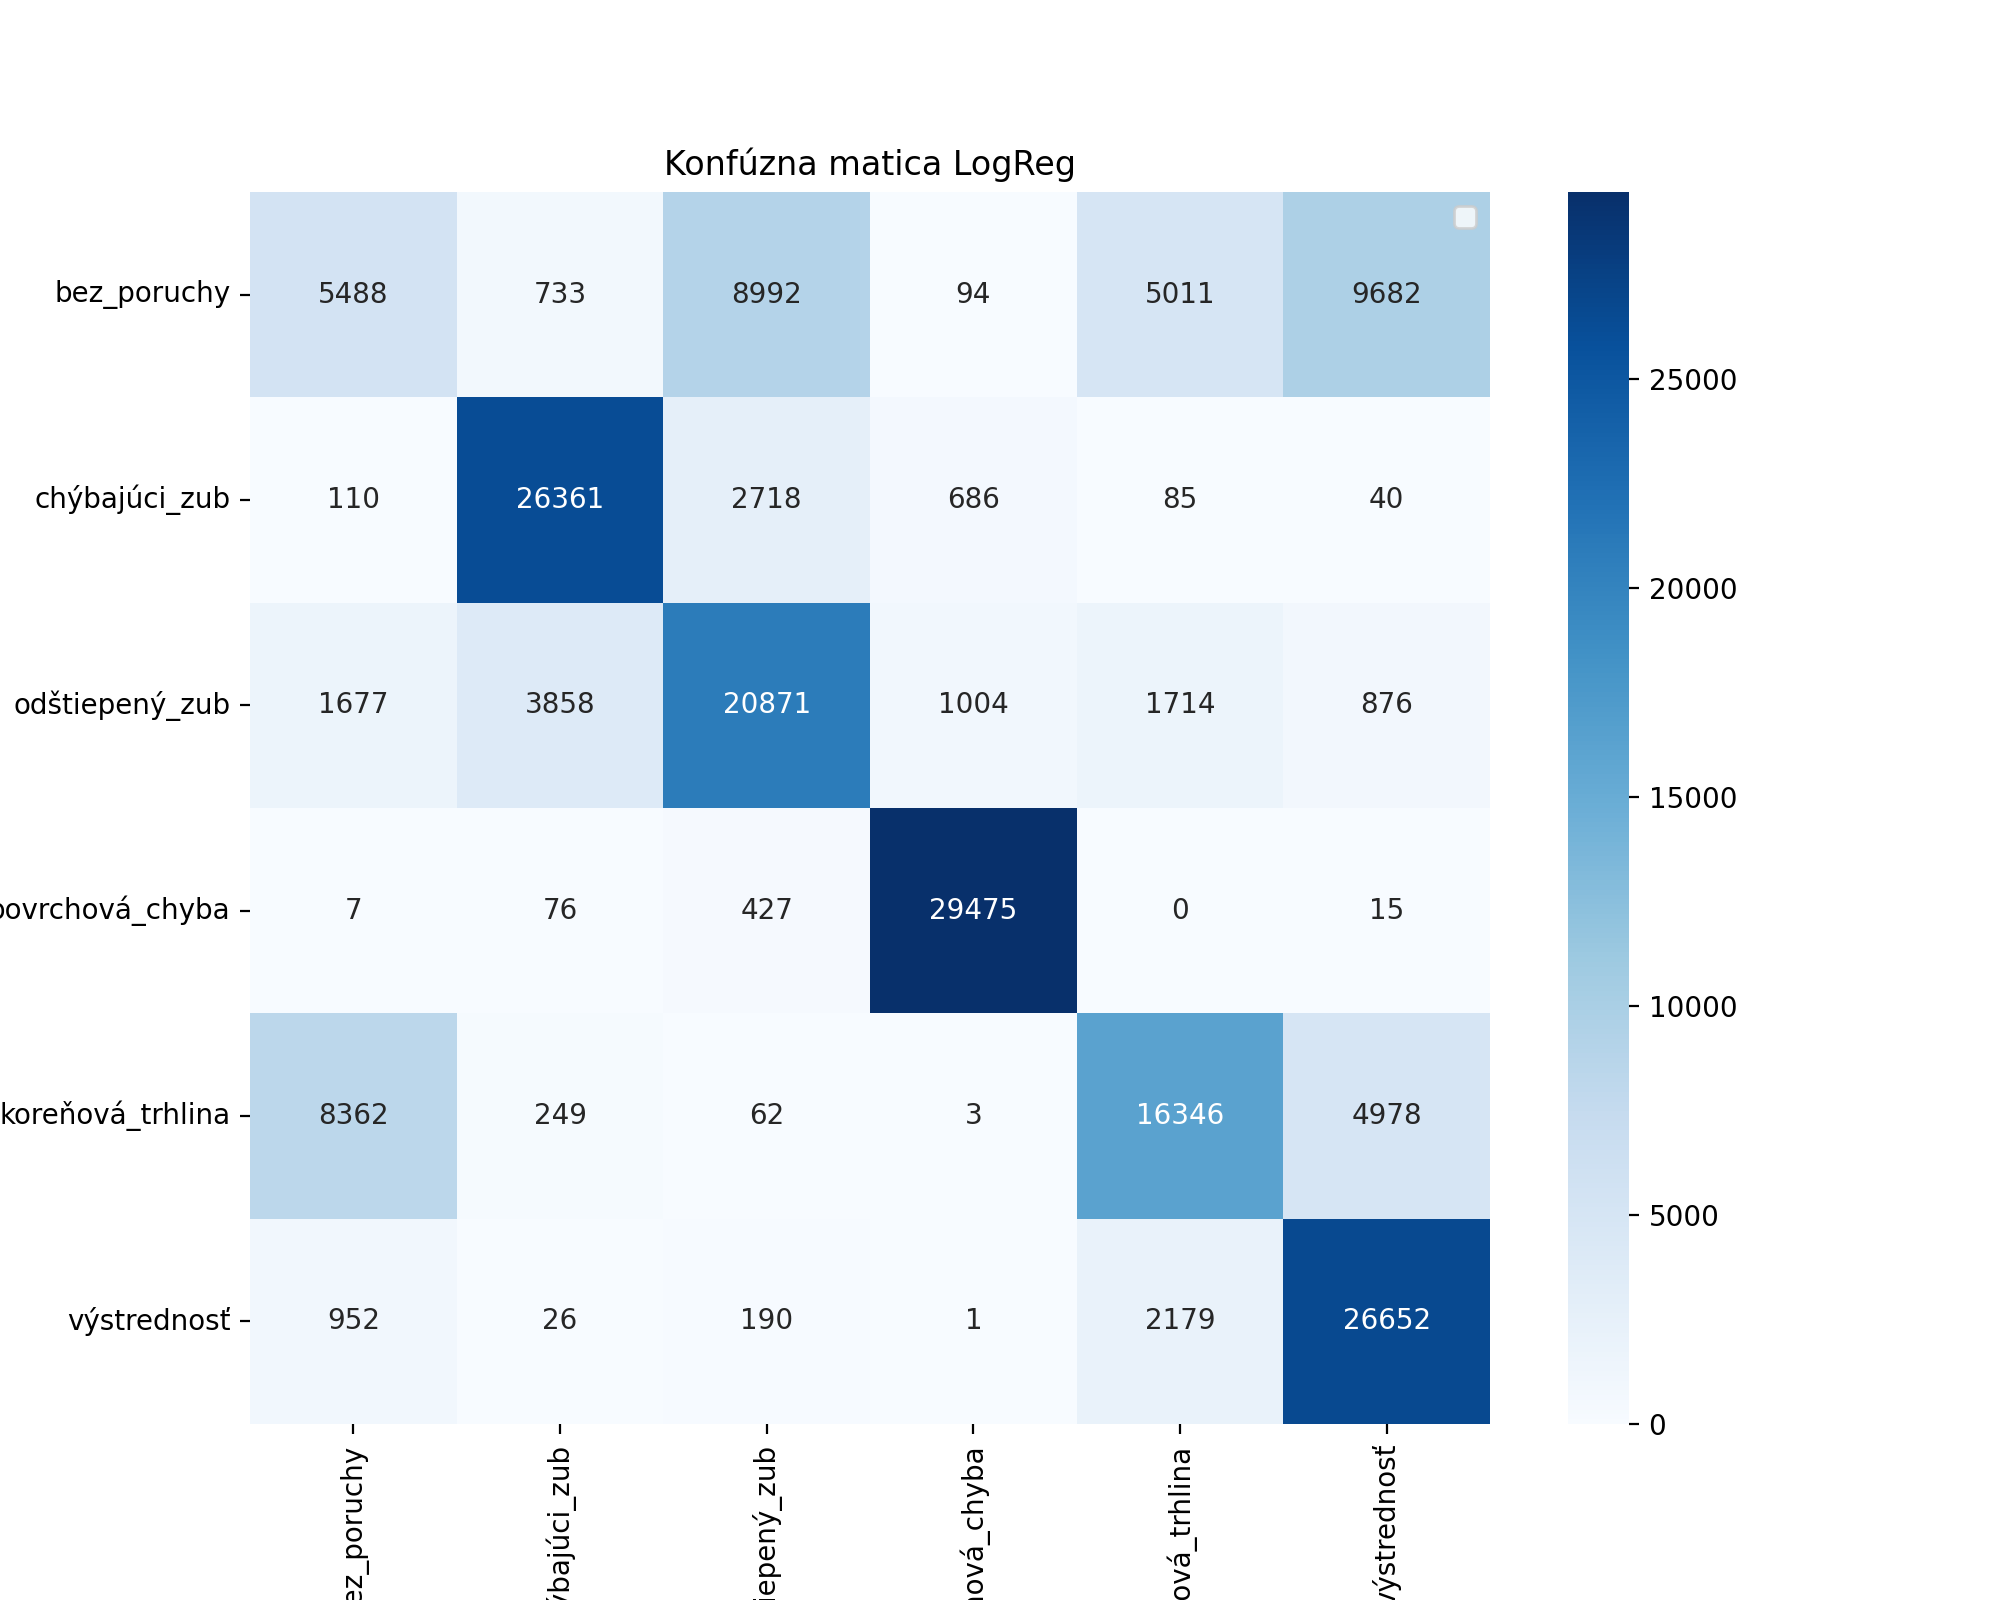

In [80]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
log_reg.classes_ = state_expected_keys.state.values
log_reg.classes_

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title('Konfúzna matica LogReg')
plt.legend([f'Presnosť: {accuracy_lr:.2f}'])
plt.show()

In [81]:
# Parameter grid for RandomizedSearch
param_grid_lgbm = {
    'num_leaves': [31],
    'min_data_in_leaf': [20],
    'max_depth': [-1],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'feature_fraction': [0.8]
}

lgb_model = lgb.LGBMClassifier()
test_times = []
train_times = []
time_start2 = time()
# Grid search
best_lgb_model = GridSearchCV(lgb_model, param_grid_lgbm, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
best_lgb_model.fit(X_train, y_train)
training_time2 = time() - time_start2
best_lgb = best_lgb_model.best_estimator_
time_test2 = time()
# Predict the test set
y_pred = best_lgb.predict(X_test)
test_times.append(time() - time_test2)
train_times.append(training_time2)
# Calculate the accuracy
accuracy_lgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_lgb))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))


# Save the model to a file
model_name = f'lightgbm_{accuracy_lgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_lgb, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_lgb}\n")
    f.write(f"Training Time: {training_time2} seconds\n")
    f.write(f"Hyperparameters: {best_lgb.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12713
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 54
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791

None

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     30000
           1       0.94      0.95      0.94     30000
           2       0.94      0.94      0.94     30000
           3       1.00      1.00      1.00     30000
           4       0.97      0.97      0.97     30000
           5       1.00      0.99      0.99     30000

    accuracy                           0.97    180000
   macro avg       0.97      0.97      0.97    180000
weighted avg       0.97      0.97      0.97    180000



None

Model and metadata saved in models


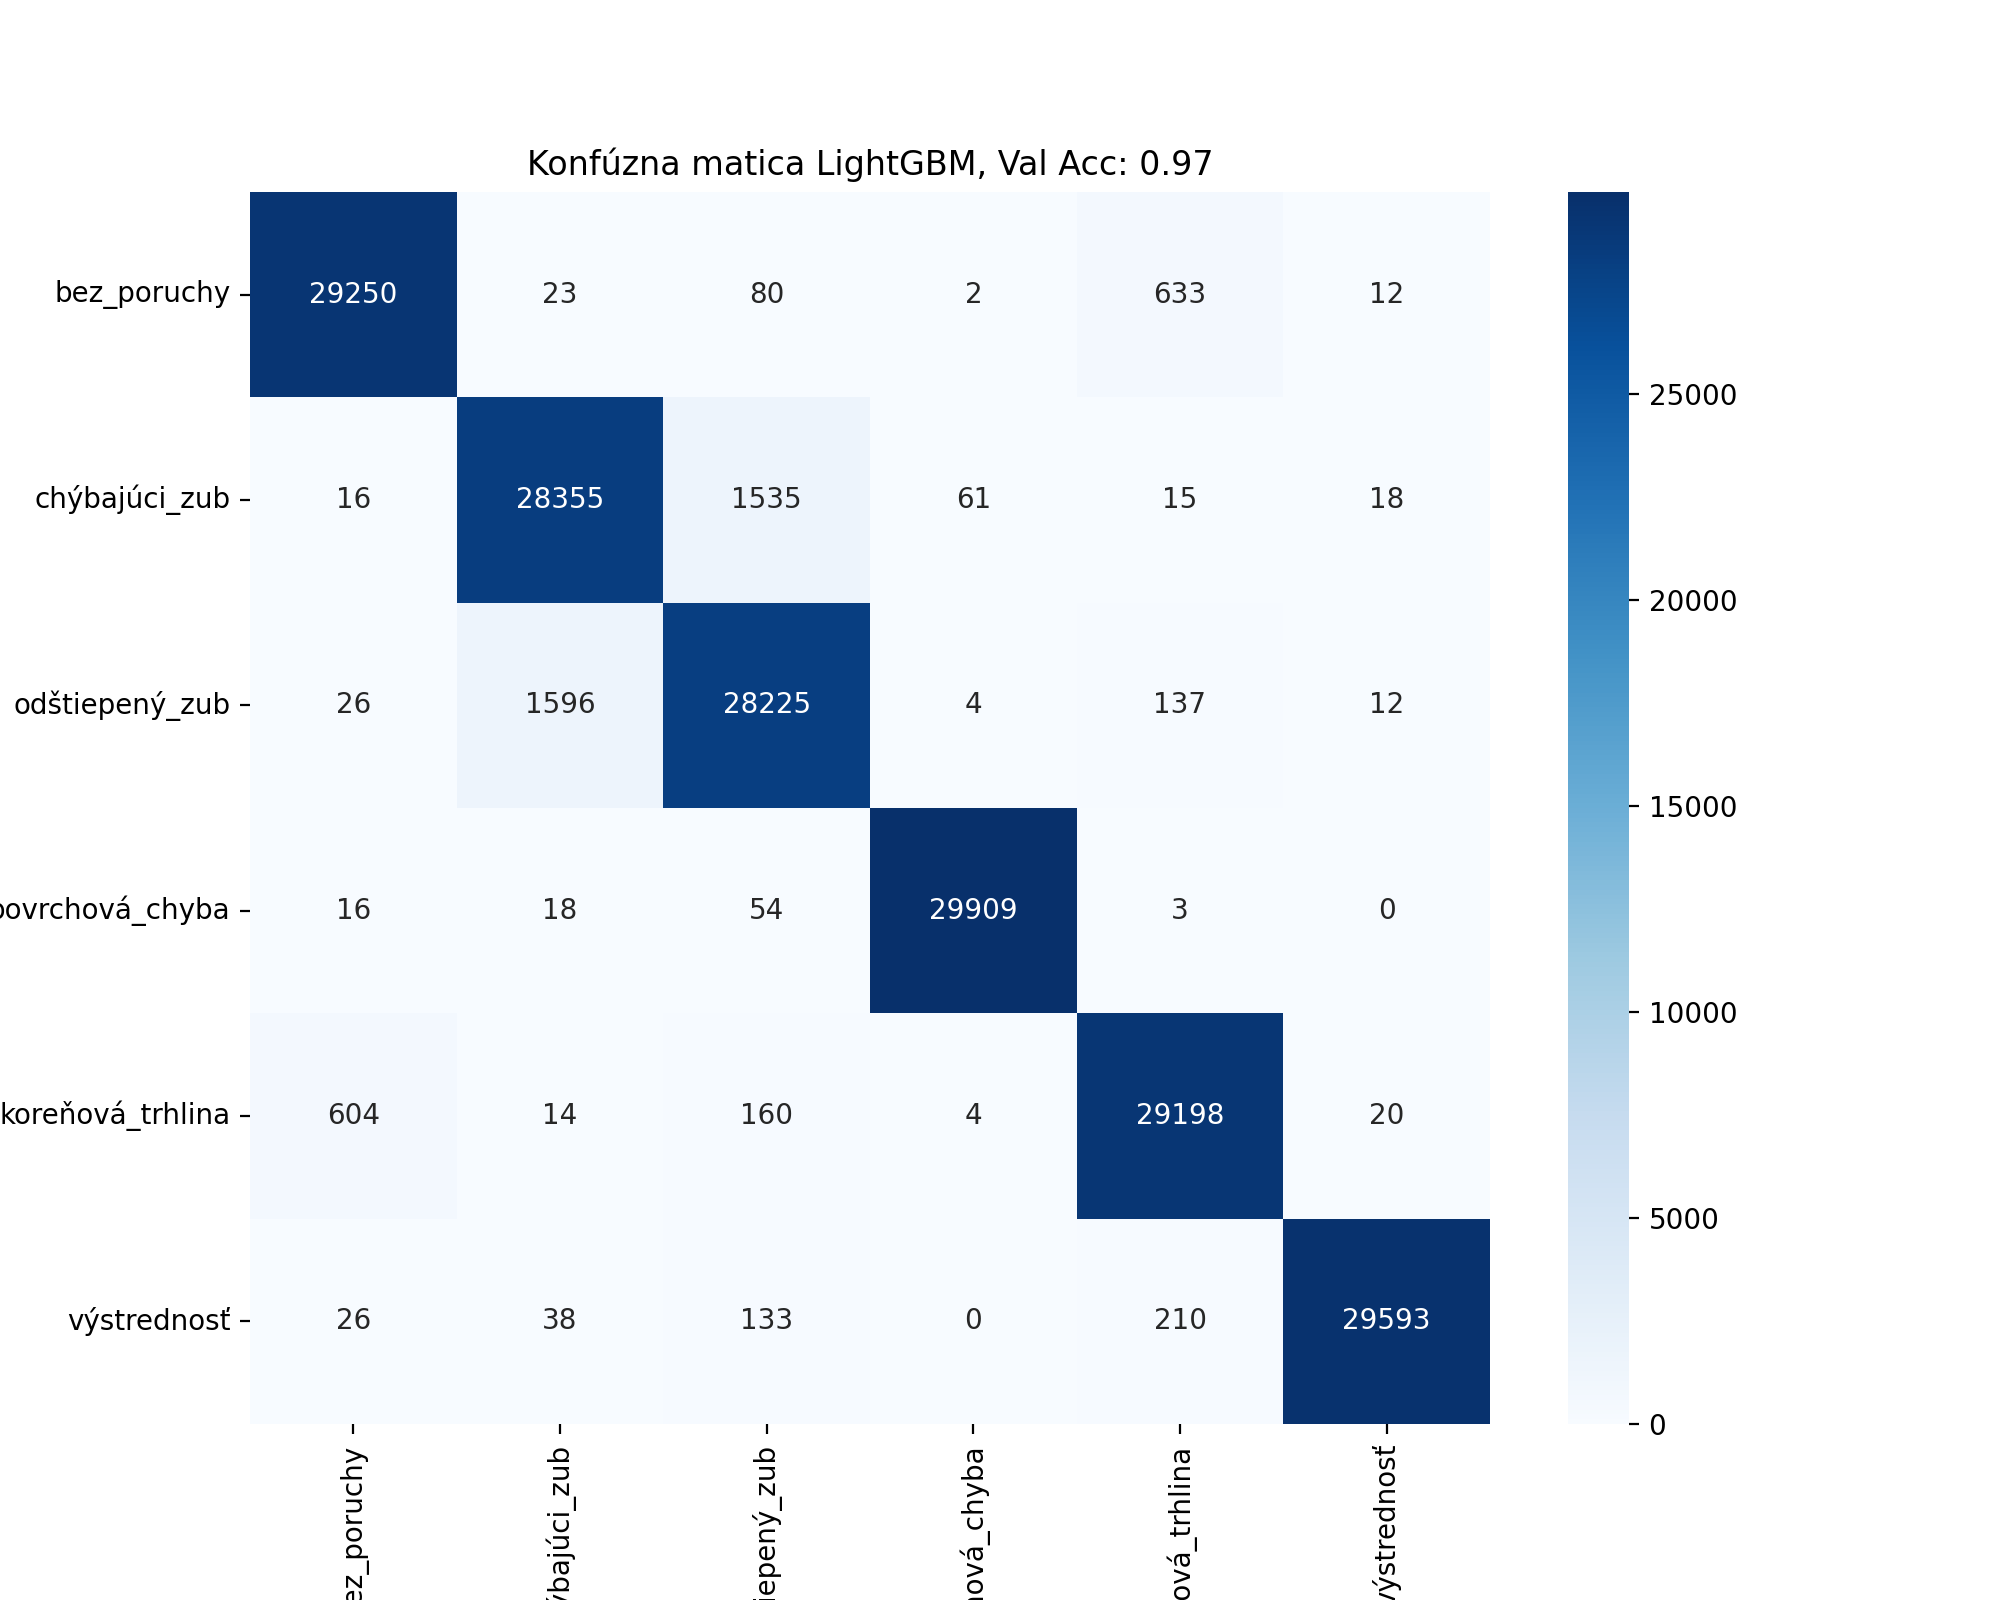

In [82]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names in someway
predicted_names = [mapping_dict[label] for label in best_lgb.classes_]
# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predikované')
plt.ylabel('Aktuálne')
plt.title(f'Konfúzna matica LightGBM, Val Acc: {accuracy_lgb:.2f}')
plt.show()

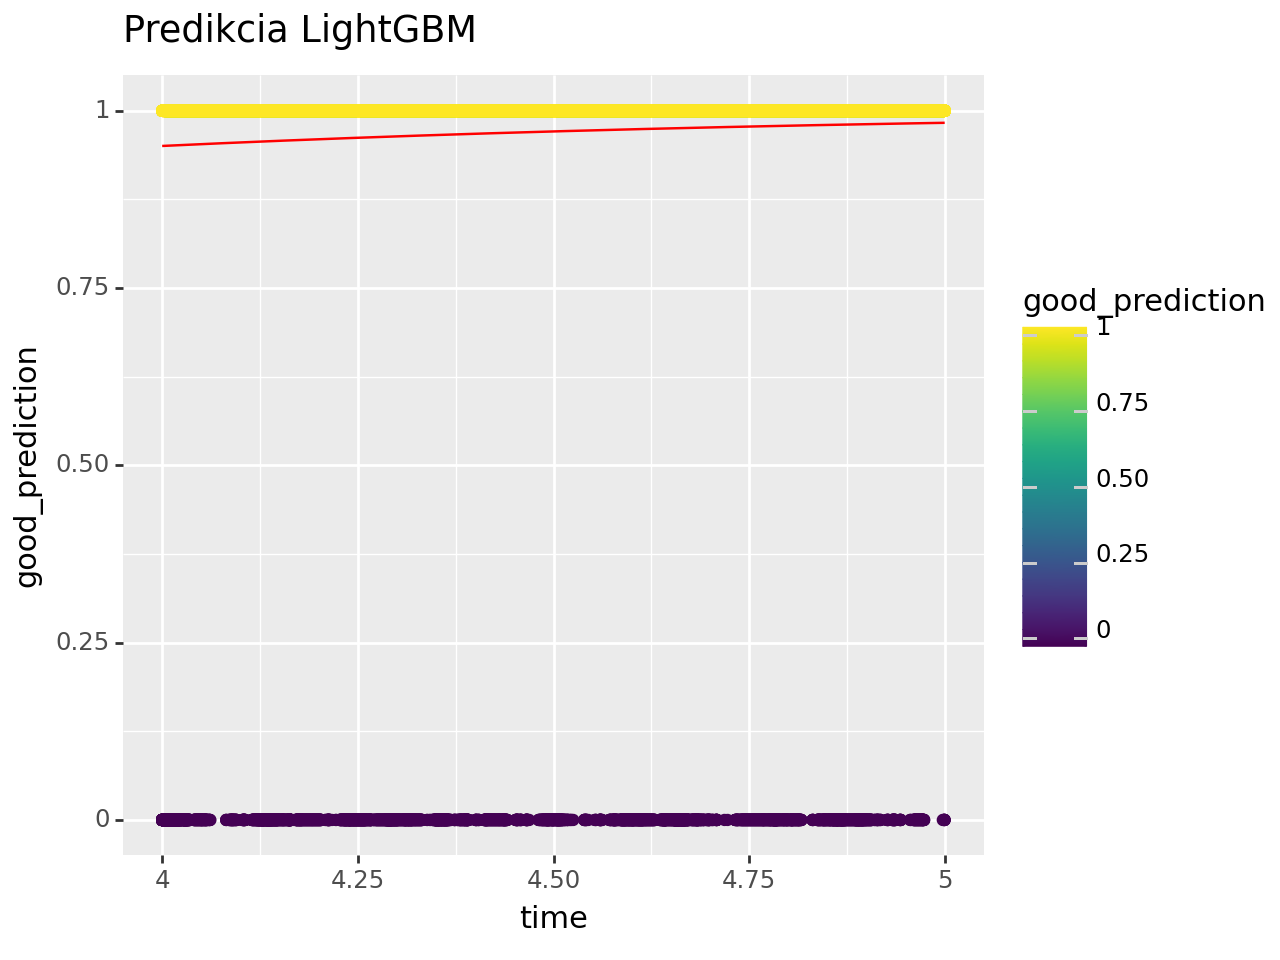

<Figure Size: (640 x 480)>

In [83]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia LightGBM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [84]:
# Create XGB Classifier
param_grid_xgb = {
    'max_depth': [6],
    'gamma': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'learning_rate': [0.1],
    'n_estimators': [200]
}

# Setup the model
xgb_model = xgb.XGBClassifier()

start_time3 = time()
grid_search_xgb = RandomizedSearchCV(xgb_model, param_grid_xgb, cv=4, verbose=1, scoring='accuracy', n_jobs=-1)
# Pick the best model
grid_search_xgb.fit(X_train, y_train)
training_time3 = time() - start_time3
best_xgb = best_lgb_model.best_estimator_
time_test3 = time()
# Predict the test set
y_pred = best_xgb.predict(X_test)
test_times.append(time() - time_test3)
train_times.append(training_time3)

# Calculate the accuracy
accuracy_xgb = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_xgb))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'xgboost_{accuracy_xgb:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_xgb, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_xgb}\n")
    f.write(f"Training Time: {training_time3} seconds\n")
    f.write(f"Hyperparameters: {best_xgb.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")

c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.


Fitting 4 folds for each of 1 candidates, totalling 4 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
Accuracy: 0.9696111111111111


None

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     30000
           1       0.94      0.95      0.94     30000
           2       0.94      0.94      0.94     30000
           3       1.00      1.00      1.00     30000
           4       0.97      0.97      0.97     30000
           5       1.00      0.99      0.99     30000

    accuracy                           0.97    180000
   macro avg       0.97      0.97      0.97    180000
weighted avg       0.97      0.97      0.97    180000



None

Model and metadata saved in models


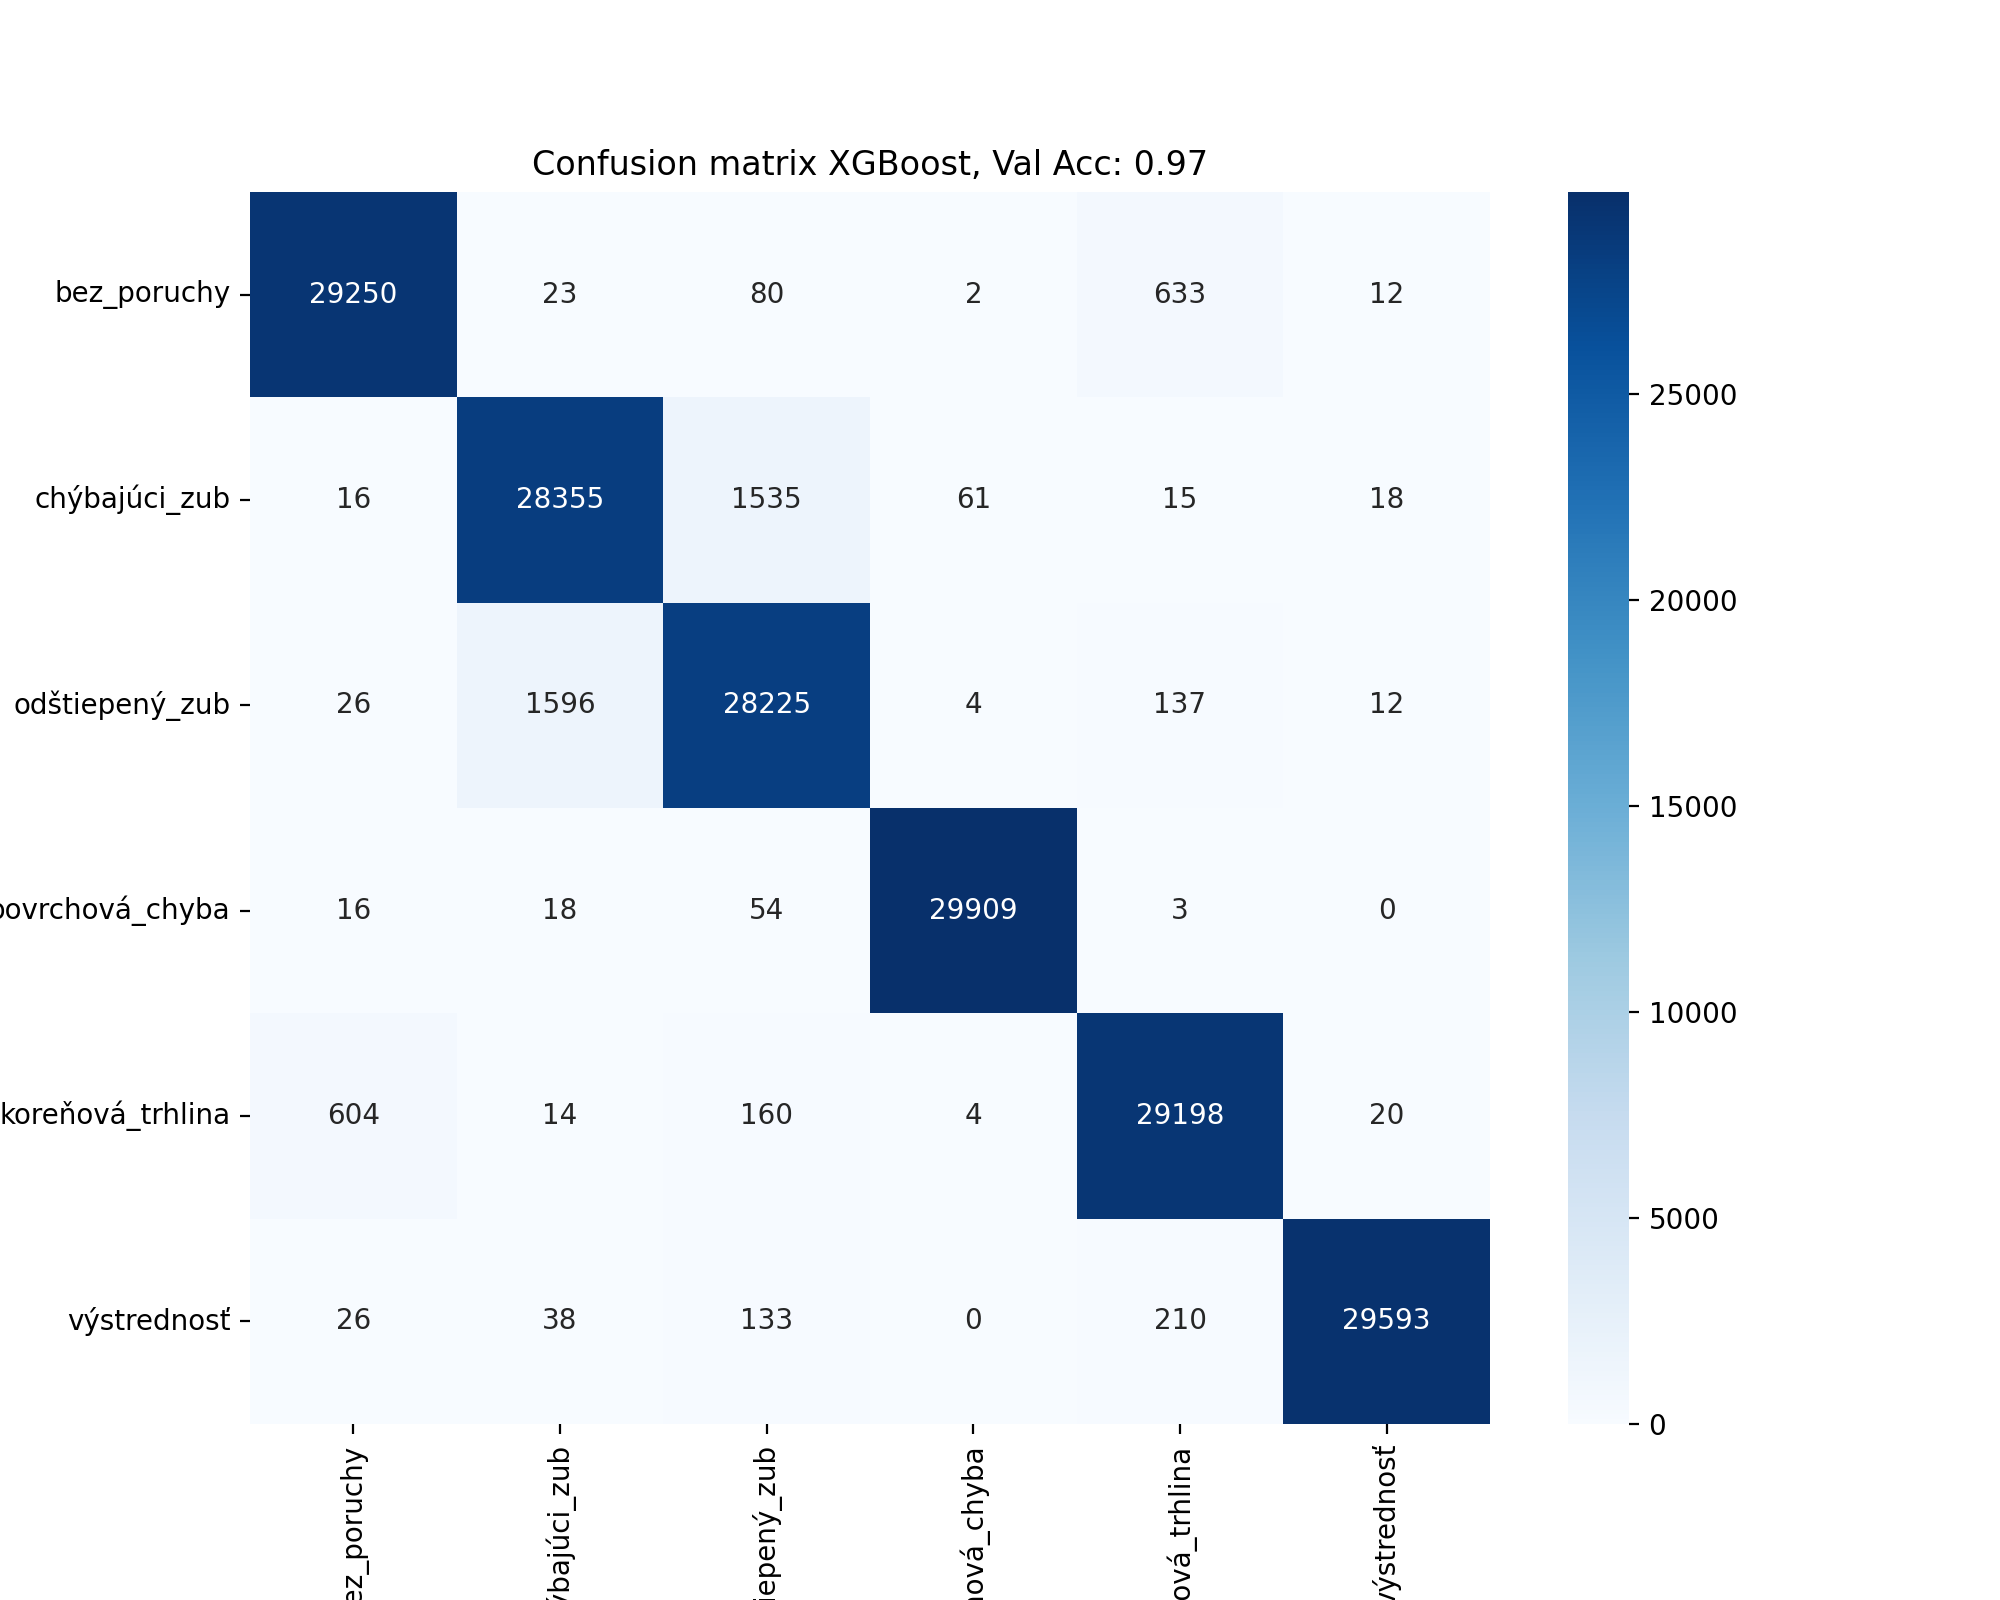

In [85]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_xgb.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix XGBoost, Val Acc: {accuracy_xgb:.2f}')
plt.show()

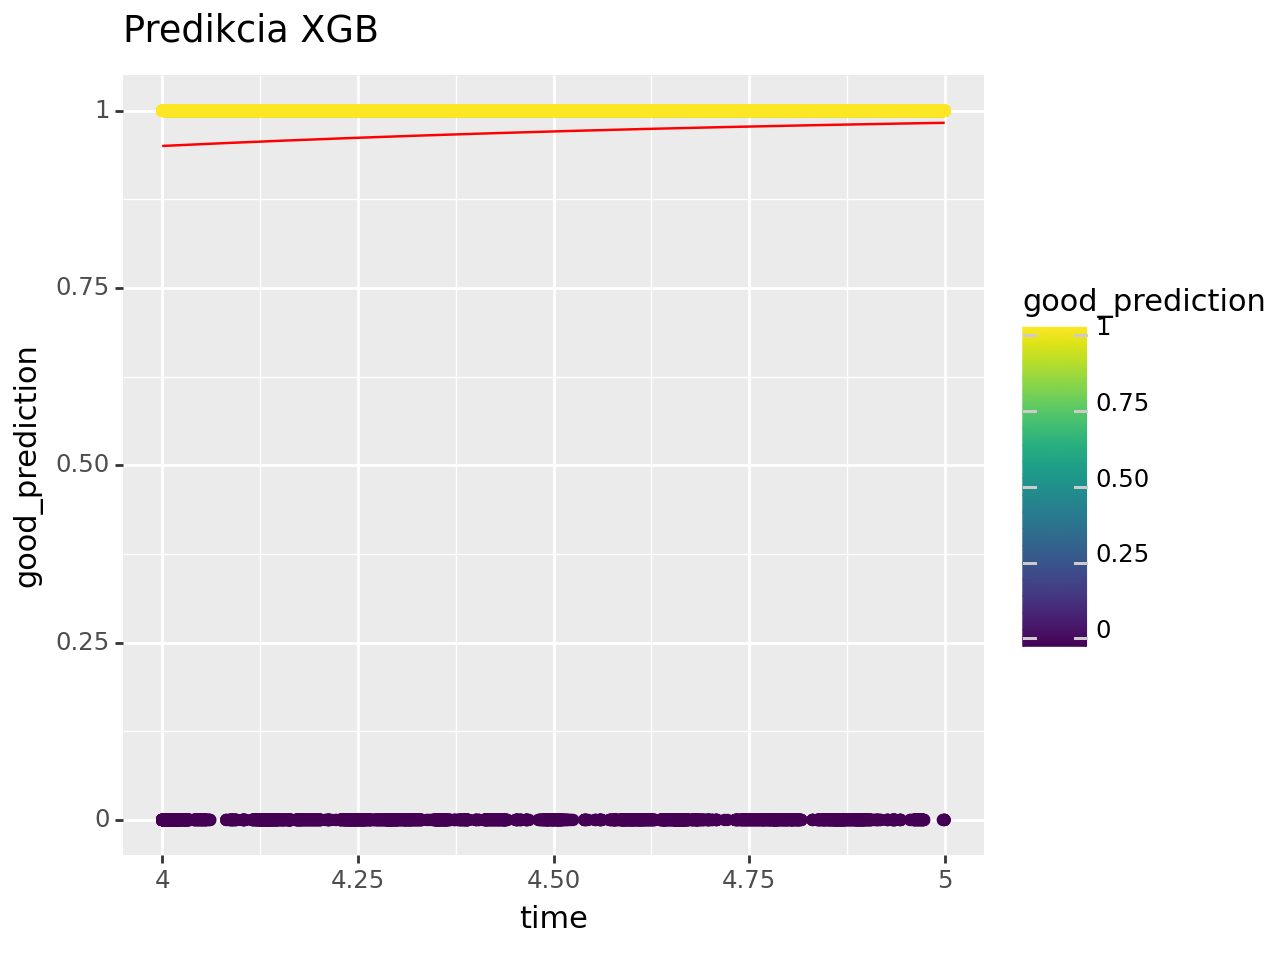

<Figure Size: (640 x 480)>

In [86]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia XGB'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [87]:
"""
# Create a KNN model for classification using the df dataset print the accuracy of the model
param_grid_knn = {
    'n_neighbors': [20],
    'weights': ['uniform'],
    'metric': ['manhattan']
}

# Setup the model
knn_model = KNeighborsClassifier()

start_time4 = time()
# Pick the best model
best_knn_model = GridSearchCV(knn_model, param_grid_knn, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
best_knn_model.fit(X_train, y_train)
training_time4 = time() - start_time4

best_knn = best_knn_model.best_estimator_
time_test4 = time()
# Predict the test set
y_pred = best_knn.predict(X_test)
test_times.append(time() - time_test4)
train_times.append(training_time4)

# Calculate the accuracy
accuracy_knn = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_knn))

# Save the model to a file
model_name = f'knn_{accuracy_knn:.4f}'
model_directory = 'models'   
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_knn, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_knn}\n")
    f.write(f"Training Time: {training_time4} seconds\n")
    f.write(f"Hyperparameters: {best_knn.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_knn.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix KNN, Val Acc: {accuracy_xgb:.2f}')
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia KNN'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot
"""

'\n# Create a KNN model for classification using the df dataset print the accuracy of the model\nparam_grid_knn = {\n    \'n_neighbors\': [20],\n    \'weights\': [\'uniform\'],\n    \'metric\': [\'manhattan\']\n}\n\n# Setup the model\nknn_model = KNeighborsClassifier()\n\nstart_time4 = time()\n# Pick the best model\nbest_knn_model = GridSearchCV(knn_model, param_grid_knn, cv=4, scoring=\'accuracy\', verbose=1, n_jobs=-1)\nbest_knn_model.fit(X_train, y_train)\ntraining_time4 = time() - start_time4\n\nbest_knn = best_knn_model.best_estimator_\ntime_test4 = time()\n# Predict the test set\ny_pred = best_knn.predict(X_test)\ntest_times.append(time() - time_test4)\ntrain_times.append(training_time4)\n\n# Calculate the accuracy\naccuracy_knn = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_knn))\n\n# Save the model to a file\nmodel_name = f\'knn_{accuracy_knn:.4f}\'\nmodel_directory = \'models\'   \nmodel_path = f\'{model_directory}/{model_name}.h5\'\njoblib.dump(best_knn

In [88]:
"""
# Random Forest
param_grid_rf = {
    'n_estimators': [200],
    'max_features': ['sqrt'],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Setup the model
rf_model = RandomForestClassifier()

start_time5 = time()
# Pick the best model
best_rf_model = GridSearchCV(rf_model, param_grid_rf, cv=4, verbose=1, n_jobs=-1)
best_rf_model.fit(X_train, y_train)
training_time5 = time() - start_time5

best_rf = best_rf_model.best_estimator_
time_test5 = time()
# Predict the test set
y_pred = best_rf.predict(X_test)
test_times.append(time() - time_test5)
train_times.append(training_time5)

# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_rf))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'random_forest_{accuracy_rf:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_rf, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_rf}\n")
    f.write(f"Training Time: {training_time5} seconds\n")
    f.write(f"Hyperparameters: {best_rf.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_rf.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix RandomForest, Val Acc: {accuracy_rf:.2f}')
plt.show()
# Logistic Regression plot 
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia RF'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot
"""

'\n# Random Forest\nparam_grid_rf = {\n    \'n_estimators\': [200],\n    \'max_features\': [\'sqrt\'],\n    \'max_depth\': [20],\n    \'min_samples_split\': [2],\n    \'min_samples_leaf\': [1]\n}\n\n# Setup the model\nrf_model = RandomForestClassifier()\n\nstart_time5 = time()\n# Pick the best model\nbest_rf_model = GridSearchCV(rf_model, param_grid_rf, cv=4, verbose=1, n_jobs=-1)\nbest_rf_model.fit(X_train, y_train)\ntraining_time5 = time() - start_time5\n\nbest_rf = best_rf_model.best_estimator_\ntime_test5 = time()\n# Predict the test set\ny_pred = best_rf.predict(X_test)\ntest_times.append(time() - time_test5)\ntrain_times.append(training_time5)\n\n# Calculate the accuracy\naccuracy_rf = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_rf))\n\n# Calculate recall, precision and f1-score\ndisplay(print(classification_report(y_test, y_pred)))\n\n# Save the model to a file\nmodel_name = f\'random_forest_{accuracy_rf:.4f}\'\nmodel_directory = \'models\'\nmodel_path = 

In [89]:
# Create a decision tree model for classification using the df dataset print the accuracy of the model
param_grid_dt = {
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

# Setup the model
dt_model = DecisionTreeClassifier()

start_time6 = time()
# Pick the best model
best_dt_model = GridSearchCV(dt_model, param_grid_dt, cv=4, verbose=1, n_jobs=-1)
best_dt_model.fit(X_train, y_train)
training_time6 = time() - start_time6

best_dt = best_dt_model.best_estimator_
time_test6 = time()
# Predict the test set
y_pred = best_dt.predict(X_test)
test_times.append(time() - time_test6)
train_times.append(training_time6)

# Calculate the accuracy
accuracy_dt = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_dt))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'decision_tree_{accuracy_dt:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_dt, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_dt}\n")
    f.write(f"Training Time: {training_time6} seconds\n")
    f.write(f"Hyperparameters: {best_dt.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Accuracy: 0.9237833333333333


None

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     30000
           1       0.90      0.84      0.87     30000
           2       0.86      0.91      0.88     30000
           3       0.95      0.98      0.97     30000
           4       0.91      0.93      0.92     30000
           5       0.98      0.93      0.95     30000

    accuracy                           0.92    180000
   macro avg       0.92      0.92      0.92    180000
weighted avg       0.92      0.92      0.92    180000



None

Model and metadata saved in models


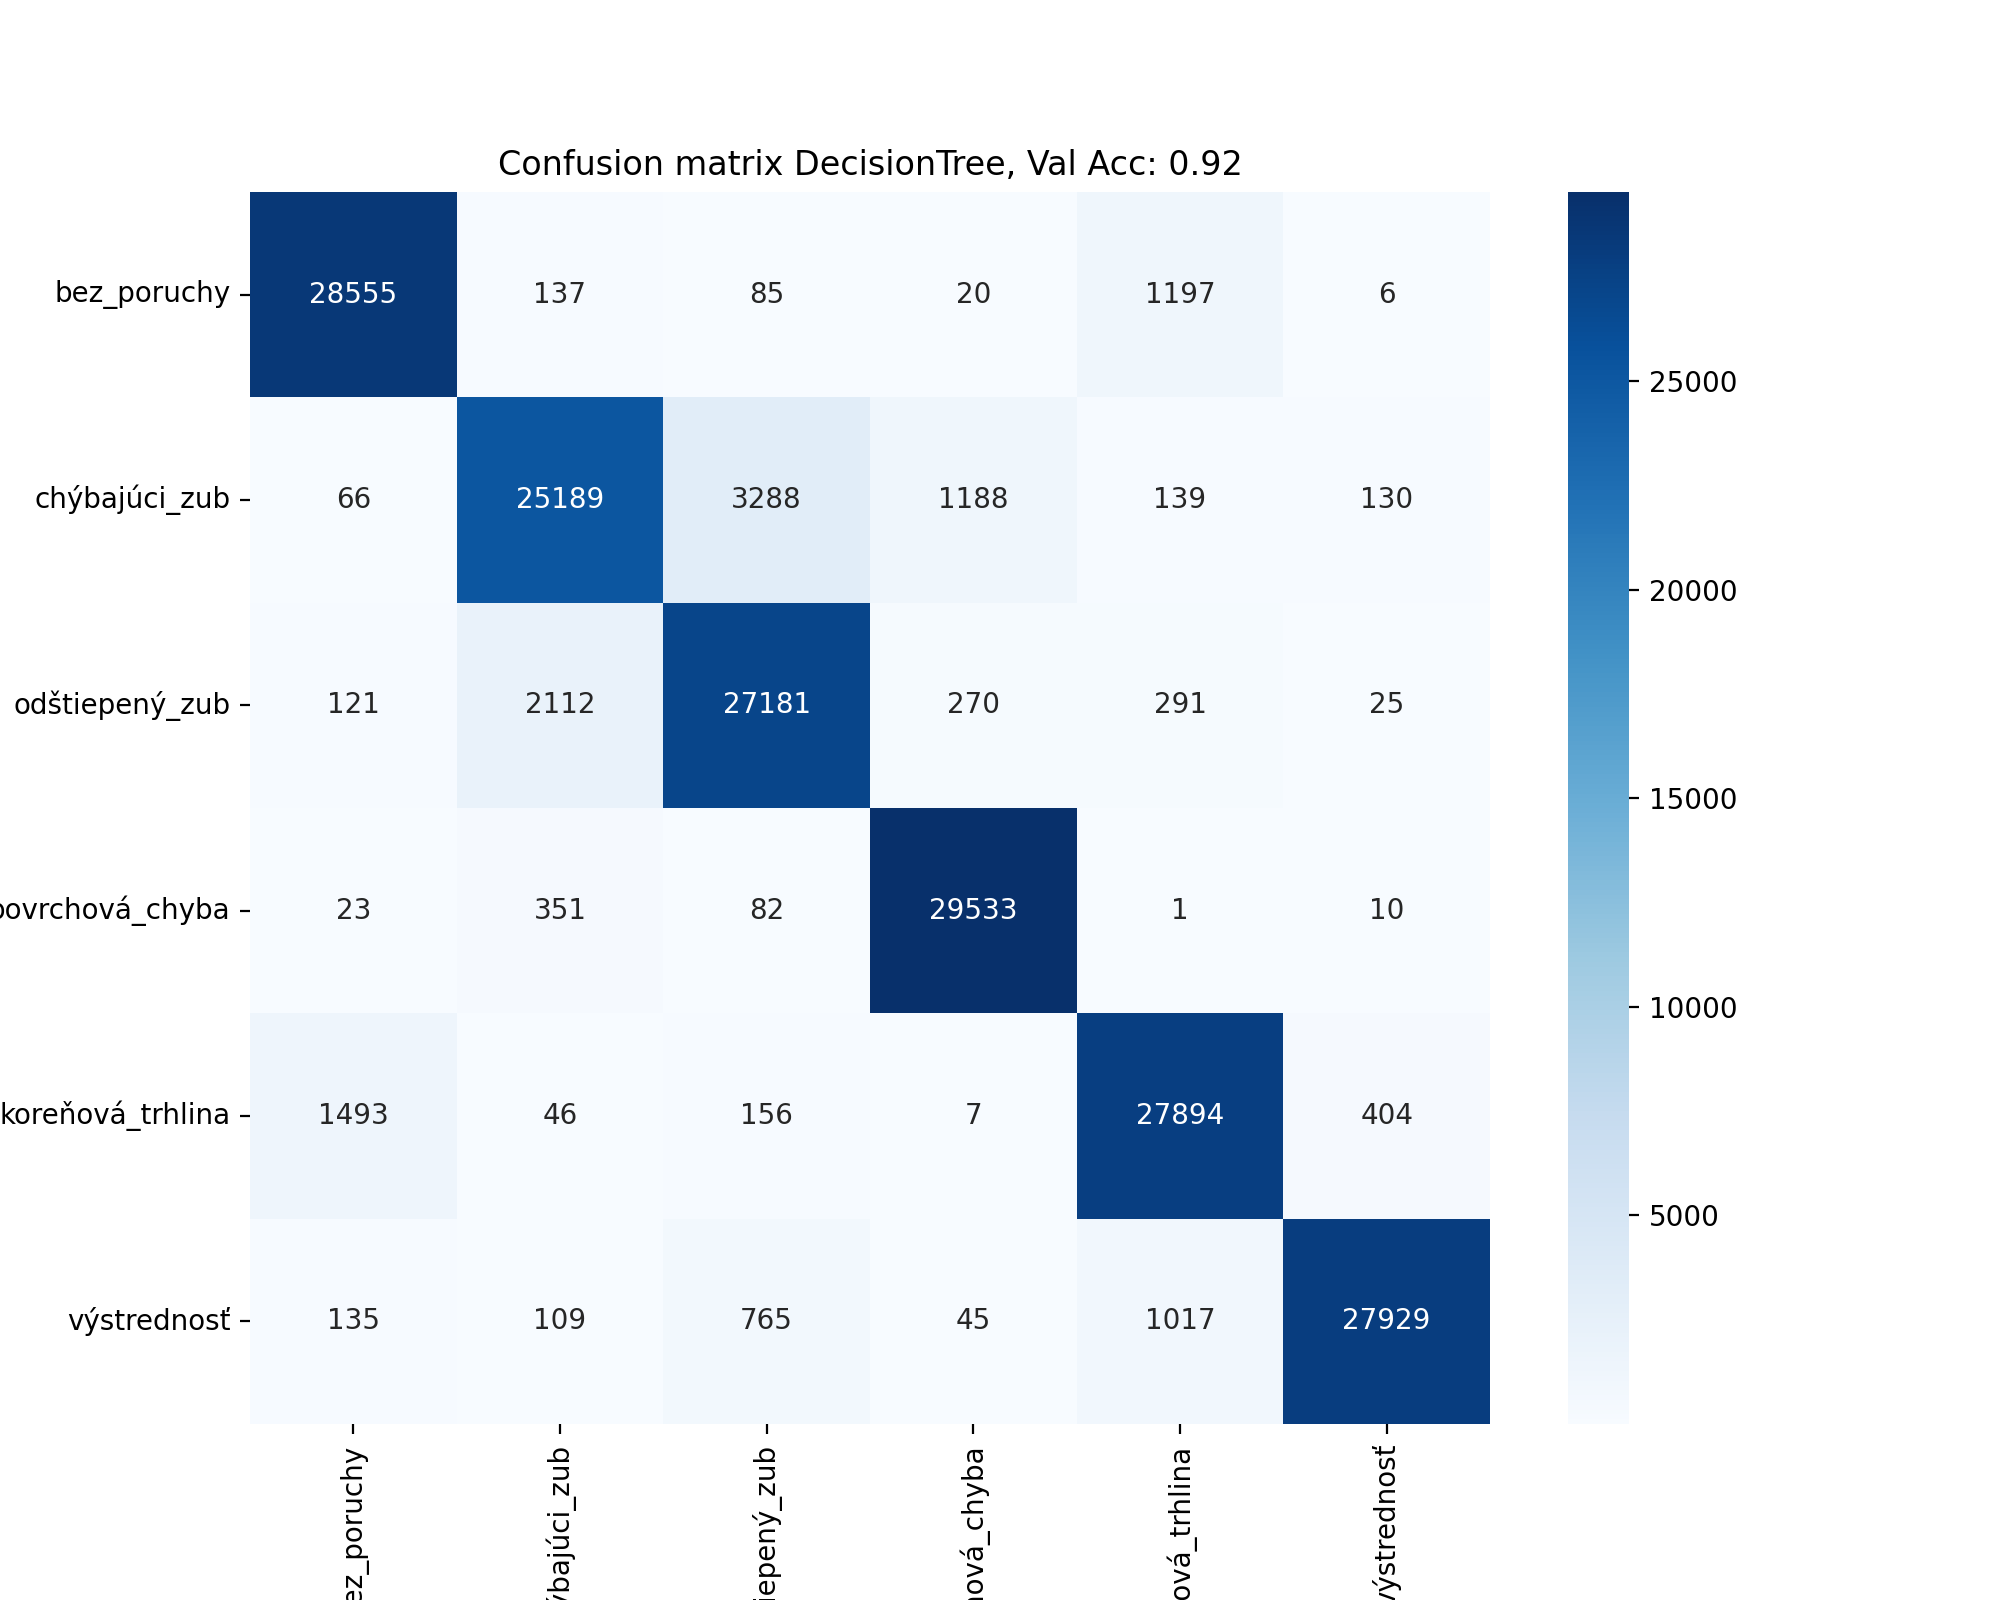

In [90]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_dt_model.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix DecisionTree, Val Acc: {accuracy_dt:.2f}')
plt.show()

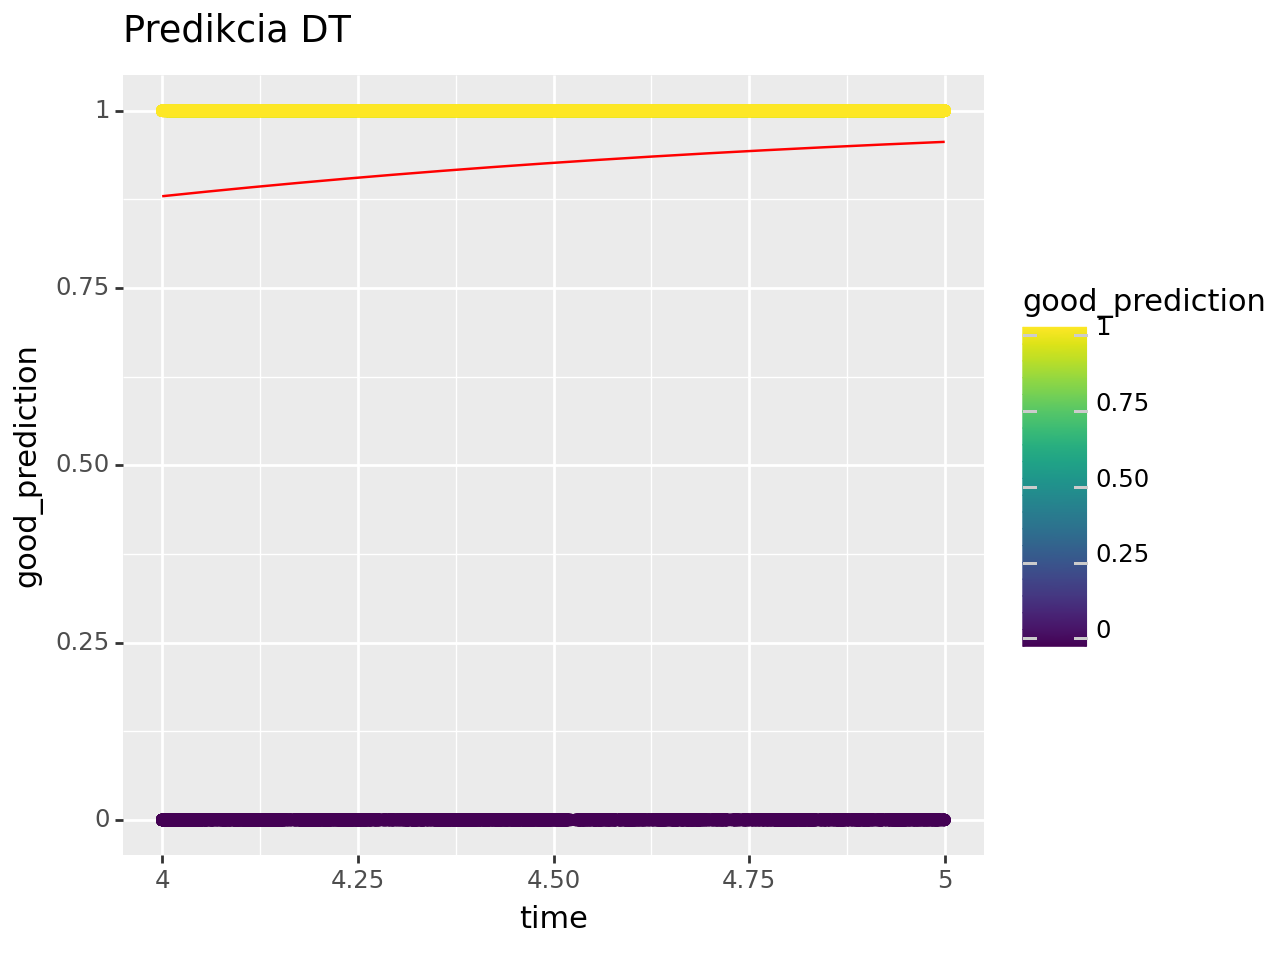

<Figure Size: (640 x 480)>

In [91]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia DT'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

In [92]:
"""
# Create the SVM model with specific parameters
random_search_svm = SVC(
        C=5, 
        gamma='scale', 
        kernel='rbf', 
        class_weight='balanced', 
        decision_function_shape='ovr'
    )

start_time7 = time()
# Pick the best model
best_svm_model = random_search_svm.fit(X_train, y_train)
training_time7 = time() - start_time7

best_svm = best_svm_model
time_test7 = time()
# Predict the test set
y_pred = best_svm.predict(X_test)
test_times.append(time() - time_test7)
train_times.append(training_time7)

# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_svm))

# Print the validation accuracy
display(print(f'Validation Accuracy for SVM: {accuracy_svm}'))

# Save the model to a file
model_name = f'svm_{accuracy_svm:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_svm, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_svm}\n")
    f.write(f"Training Time: {training_time7} seconds\n")
    f.write(f"Hyperparameters: {best_svm.get_params()}\n")

print(f"Model and metadata saved in {model_directory}")
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_svm.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix SVM, Val Acc: {accuracy_svm:.2f}')
plt.show()
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia SVM'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot
"""

'\n# Create the SVM model with specific parameters\nrandom_search_svm = SVC(\n        C=5, \n        gamma=\'scale\', \n        kernel=\'rbf\', \n        class_weight=\'balanced\', \n        decision_function_shape=\'ovr\'\n    )\n\nstart_time7 = time()\n# Pick the best model\nbest_svm_model = random_search_svm.fit(X_train, y_train)\ntraining_time7 = time() - start_time7\n\nbest_svm = best_svm_model\ntime_test7 = time()\n# Predict the test set\ny_pred = best_svm.predict(X_test)\ntest_times.append(time() - time_test7)\ntrain_times.append(training_time7)\n\n# Calculate the accuracy\naccuracy_svm = accuracy_score(y_test, y_pred)\ndisplay(print("Accuracy:", accuracy_svm))\n\n# Print the validation accuracy\ndisplay(print(f\'Validation Accuracy for SVM: {accuracy_svm}\'))\n\n# Save the model to a file\nmodel_name = f\'svm_{accuracy_svm:.4f}\'\nmodel_directory = \'models\'\nmodel_path = f\'{model_directory}/{model_name}.h5\'\njoblib.dump(best_svm, model_path)\n\n# Save the metadata\nmetadata

In [93]:
# Create a multilayer perceptron model for classification using the df dataset print the accuracy of the model
param_distributions_mlp = {
    #'hidden_layer_sizes': [(100,), (250,50)],
    'hidden_layer_sizes': [(100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    #'alpha': [0.05],
    'learning_rate': ['adaptive'],
    'max_iter': [300]
}

# Setup the model
mlp_model = MLPClassifier()

start_time8 = time()
grid_search_mlp = GridSearchCV(mlp_model, param_distributions_mlp, cv=4, scoring='accuracy', verbose=1, n_jobs=-1)
# Pick the best model
best_mlp_model = grid_search_mlp.fit(X_train, y_train)
training_time8 = time() - start_time8

best_mlp = best_mlp_model.best_estimator_
time_test8 = time()
# Predict the test set
y_pred = best_mlp.predict(X_test)
test_times.append(time() - time_test8)
train_times.append(training_time8)

# Calculate the accuracy
accuracy_mlp = accuracy_score(y_test, y_pred)
display(print("Accuracy:", accuracy_mlp))

# Calculate recall, precision and f1-score
display(print(classification_report(y_test, y_pred)))

# Save the model to a file
model_name = f'mlp_{accuracy_mlp:.4f}'
model_directory = 'models'
model_path = f'{model_directory}/{model_name}.h5'
joblib.dump(best_mlp, model_path)

# Save the metadata
metadata_path = f'{model_directory}/{model_name}_metadata.txt'
with open(metadata_path, 'w') as f:
    f.write(f"Model Name: {model_name}\n")
    f.write(f"Accuracy: {accuracy_mlp}\n")
    f.write(f"Training Time: {training_time8} seconds\n")
    f.write(f"Hyperparameters: {best_mlp.get_params()}\n")
    f.write(f"Classification Report:\n{classification_report(y_test, y_pred)}\n")

print(f"Model and metadata saved in {model_directory}")

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Accuracy: 0.9592833333333334


None

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     30000
           1       0.94      0.89      0.92     30000
           2       0.90      0.94      0.92     30000
           3       0.99      1.00      0.99     30000
           4       0.96      0.96      0.96     30000
           5       1.00      0.99      0.99     30000

    accuracy                           0.96    180000
   macro avg       0.96      0.96      0.96    180000
weighted avg       0.96      0.96      0.96    180000



None

Model and metadata saved in models


In [94]:
# Print mlp architecture
print(best_mlp.get_params())

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 300, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


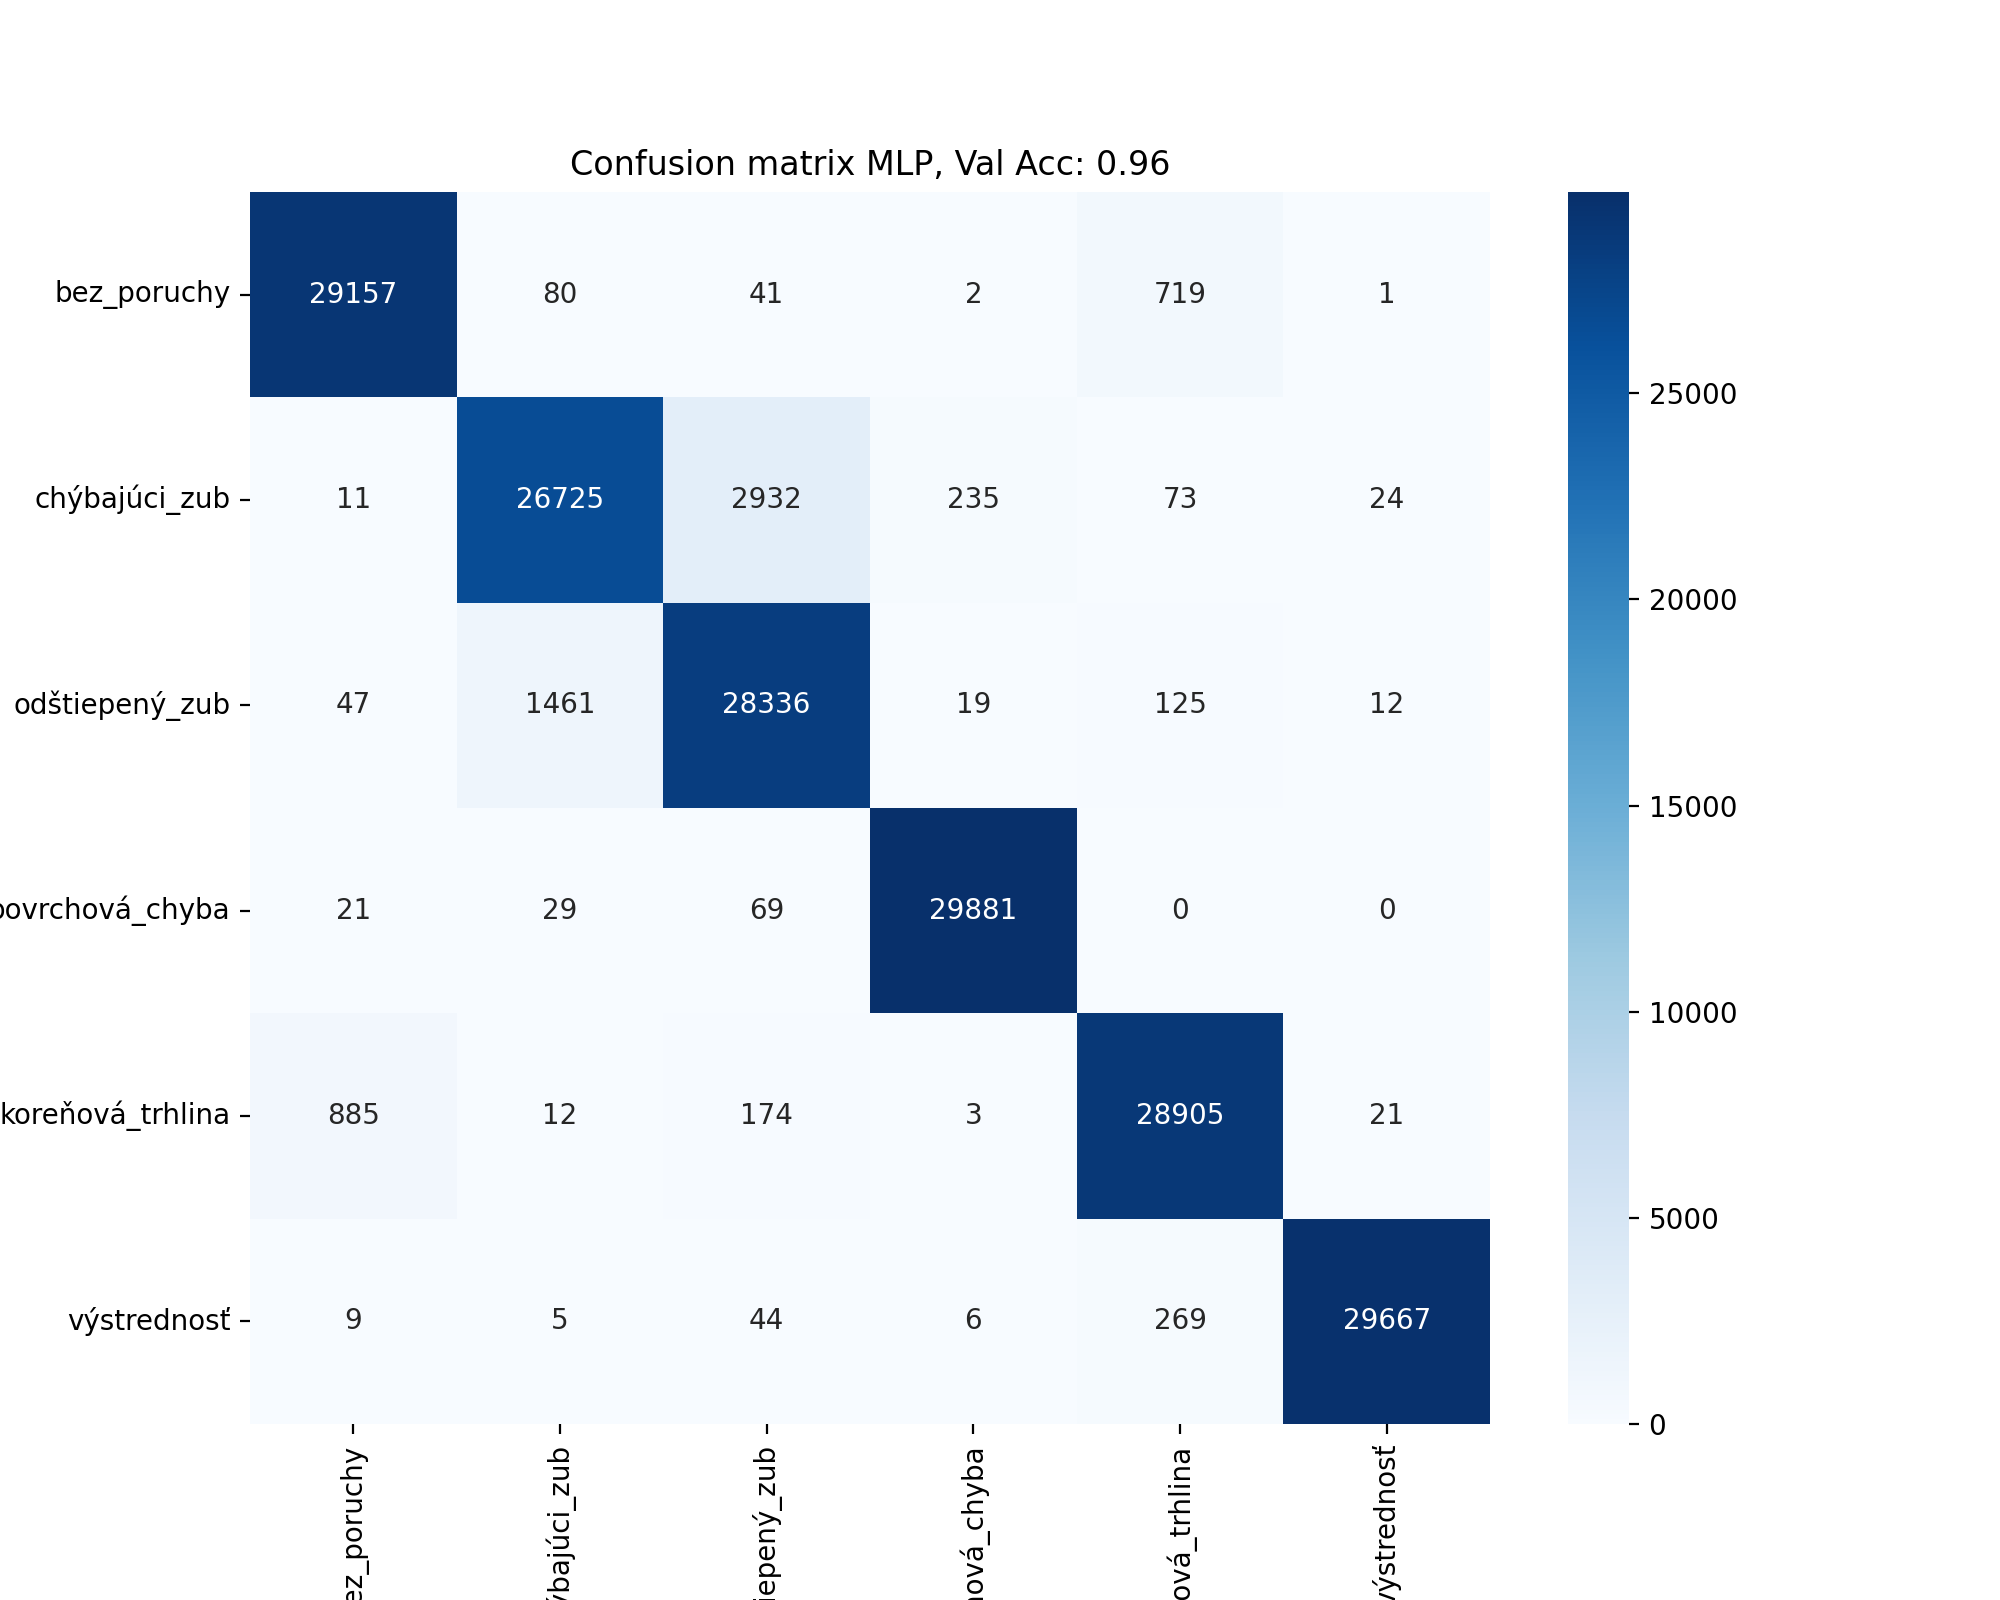

In [95]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Trasnform classes from numerical to names using state_expected_keys
predicted_names = [mapping_dict[label] for label in best_mlp.classes_]

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_names, yticklabels=predicted_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix MLP, Val Acc: {accuracy_mlp:.2f}')
plt.show()

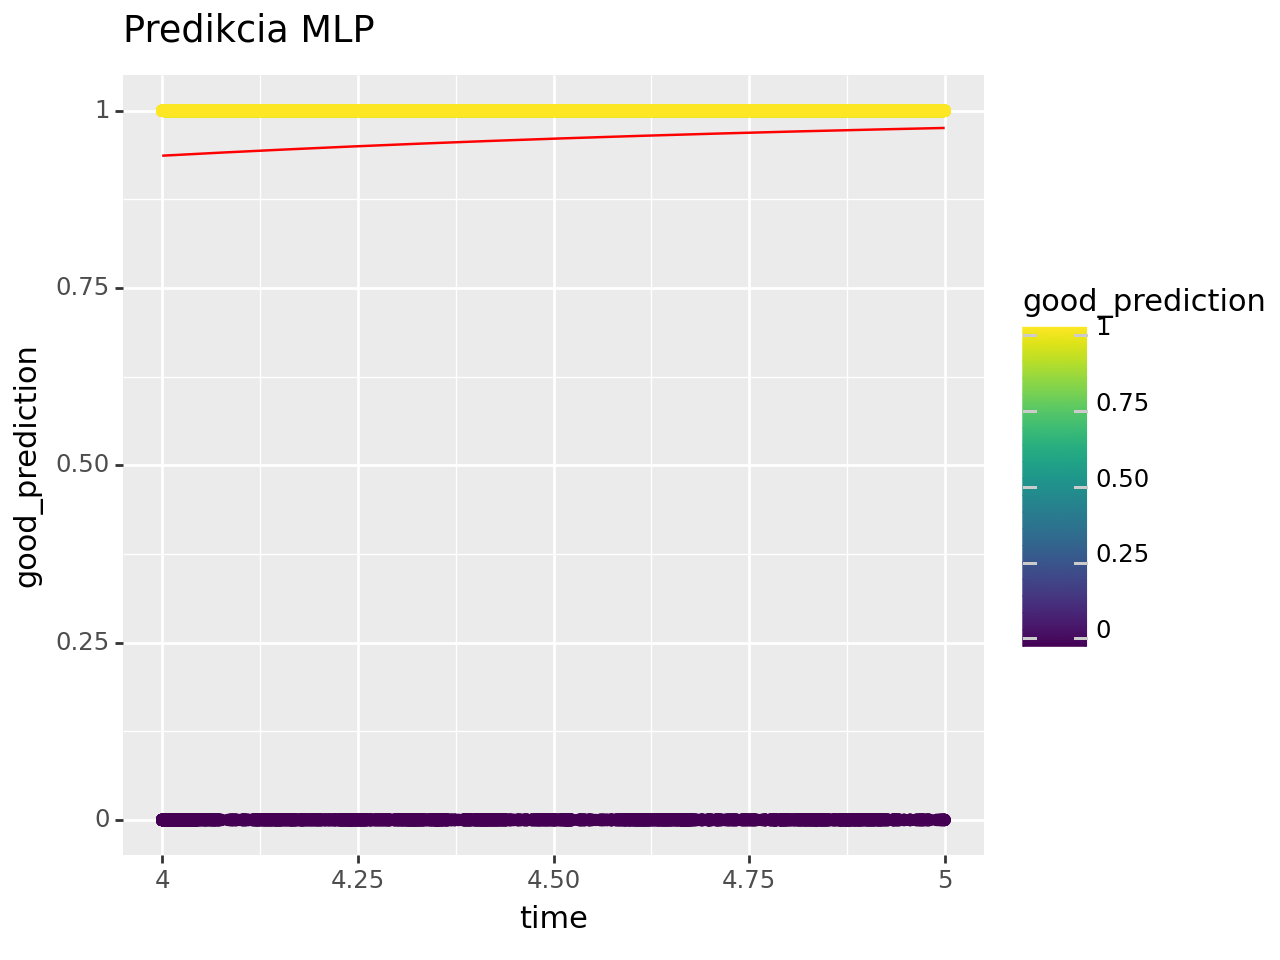

<Figure Size: (640 x 480)>

In [96]:
dfer = y_test.reset_index(drop=True).to_frame()
dfer['time'] = X_test_not_scaled.time_normalized.reset_index(drop=True)
dfer['state'] = y_pred
dfer['yval'] = y_test.reset_index(drop=True)
dfer['range'] = dfer.index
dfer['good_prediction'] = (dfer.state == dfer.yval).astype(int)

# Assuming 'time' is your feature and 'good_prediction' is the binary outcome
X = dfer[['time']].values  # Features need to be 2D for scikit-learn
y = dfer['good_prediction'].values  # Target variable

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X, y)

# Generate a range of x-values for predictions
x_range = np.linspace(dfer['time'].min(), dfer['time'].max(), 300).reshape(-1, 1)

# Predict probabilities for the generated x-values
y_pred = model.predict_proba(x_range)[:, 1]  # Get probabilities for the positive class

# Original data points
original_plot = (ggplot(dfer, aes(x='time', y='good_prediction', color='good_prediction')) +
                 geom_point() +
                 ggtitle('Predikcia MLP'))

# Create a DataFrame for the logistic curve
logistic_df = pd.DataFrame({'time': x_range.flatten(), 'probability': y_pred})

# Add the logistic curve to the plot
logistic_plot = (original_plot +
                 geom_line(data=logistic_df, mapping=aes(x='time', y='probability'), color='red'))

logistic_plot

Best model: lightGBM, Validation Accuracy: 0.9696111111111111


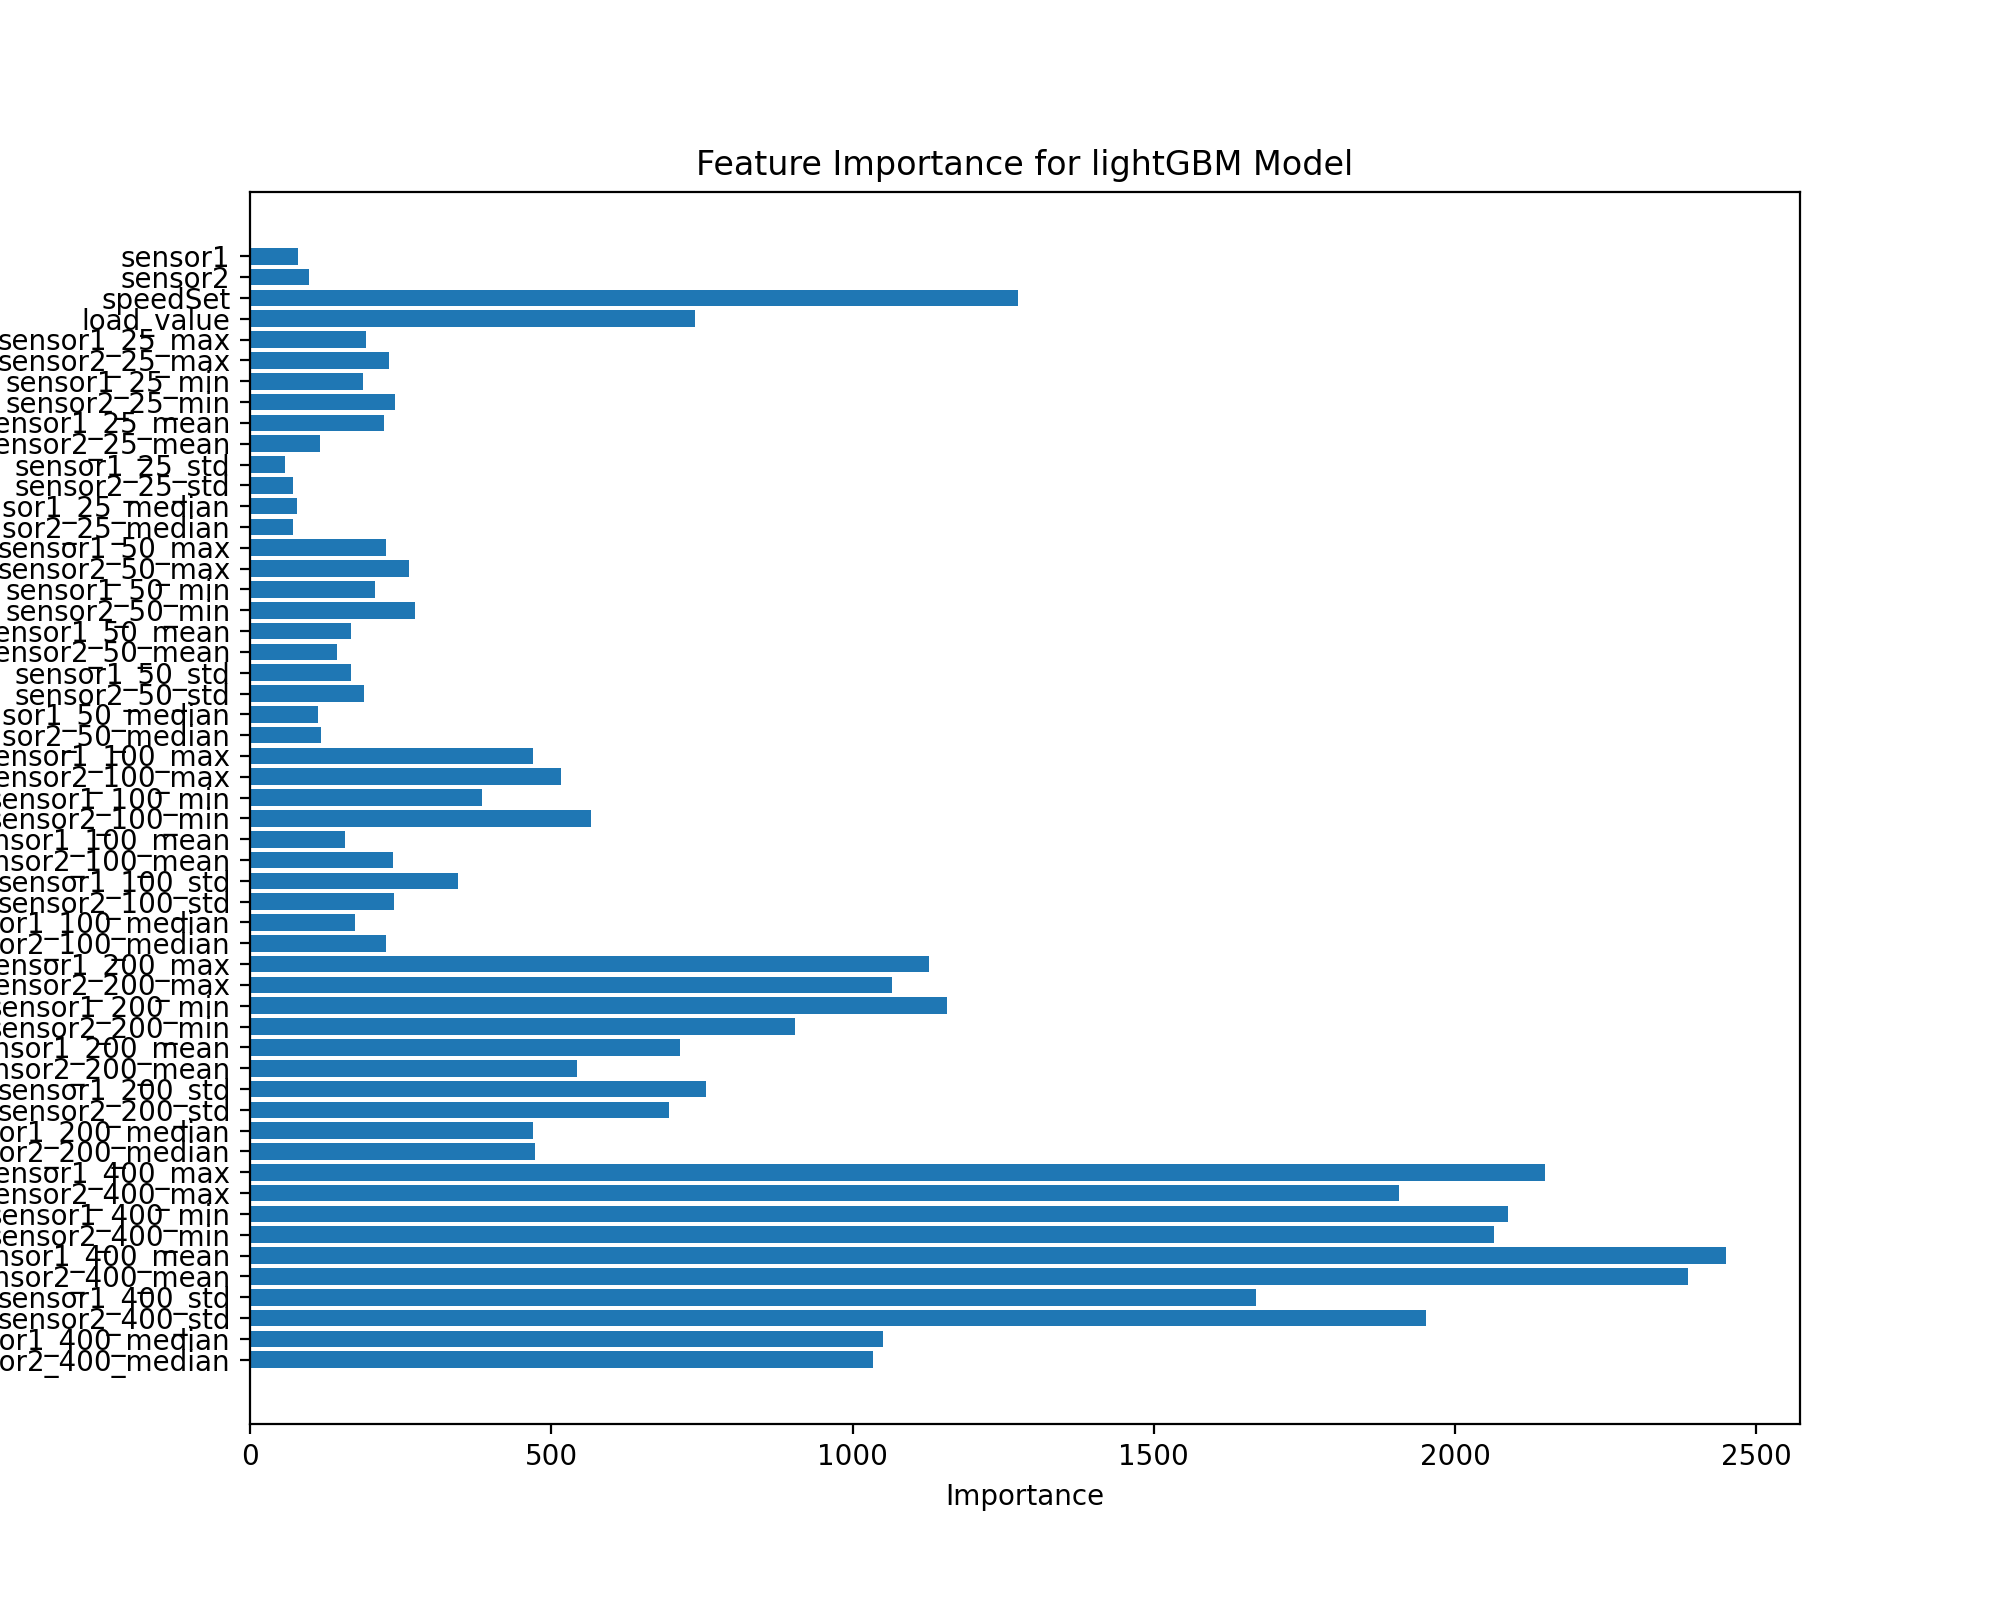

In [97]:
# Find the best models trained so far and print their names and validation accuracies and do feature importance the model
# with the highest validation accuracy

models = {
    'lightGBM': accuracy_lgb,
    'xgboost': accuracy_xgb,
    #'knn': accuracy_knn,
    #'random_forest': accuracy_rf,
    'decision_tree': accuracy_dt,
    #'svm': accuracy_svm,
    'mlp': accuracy_mlp,
}

# Find the best model
best_model_name = max(models, key=models.get)
best_model_accuracy = models[best_model_name]

print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')

# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Feature importance
# If knn then we do it differently
if best_model_name == 'knn':
    # Perform permutation importance
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()
# And if mlp then we do it differently
elif best_model_name == 'mlp':
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()
elif best_model_name == 'svm':
    feature_imp = permutation_importance(best_model, X_test, y_test, n_repeats=1, random_state=42, n_jobs=-1)
    sorted_idx = feature_imp.importances_mean.argsort()
    plt.barh(X_test_not_scaled.columns[sorted_idx], feature_imp.importances_mean[sorted_idx])
    plt.xlabel("Permutation Importance")
    plt.show()

else:
    feature_imp = best_model.feature_importances_
    X_test_not_scaled_droped = X_test_not_scaled.drop(columns=['time_normalized', 'state_expected'])

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    plt.barh(X_test_not_scaled_droped.columns, feature_imp)
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importance for {best_model_name} Model')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
    plt.show()
    
plt.savefig(f'plots/feature_importance_{best_model_name}_{best_model_accuracy:.4f}.png')

Best model: lightgbm, Validation Accuracy: 0.9696
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12713
[LightGBM] [Info] Number of data points in the train set: 720000, number of used features: 54
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Ligh

None

<Figure size 640x480 with 0 Axes>

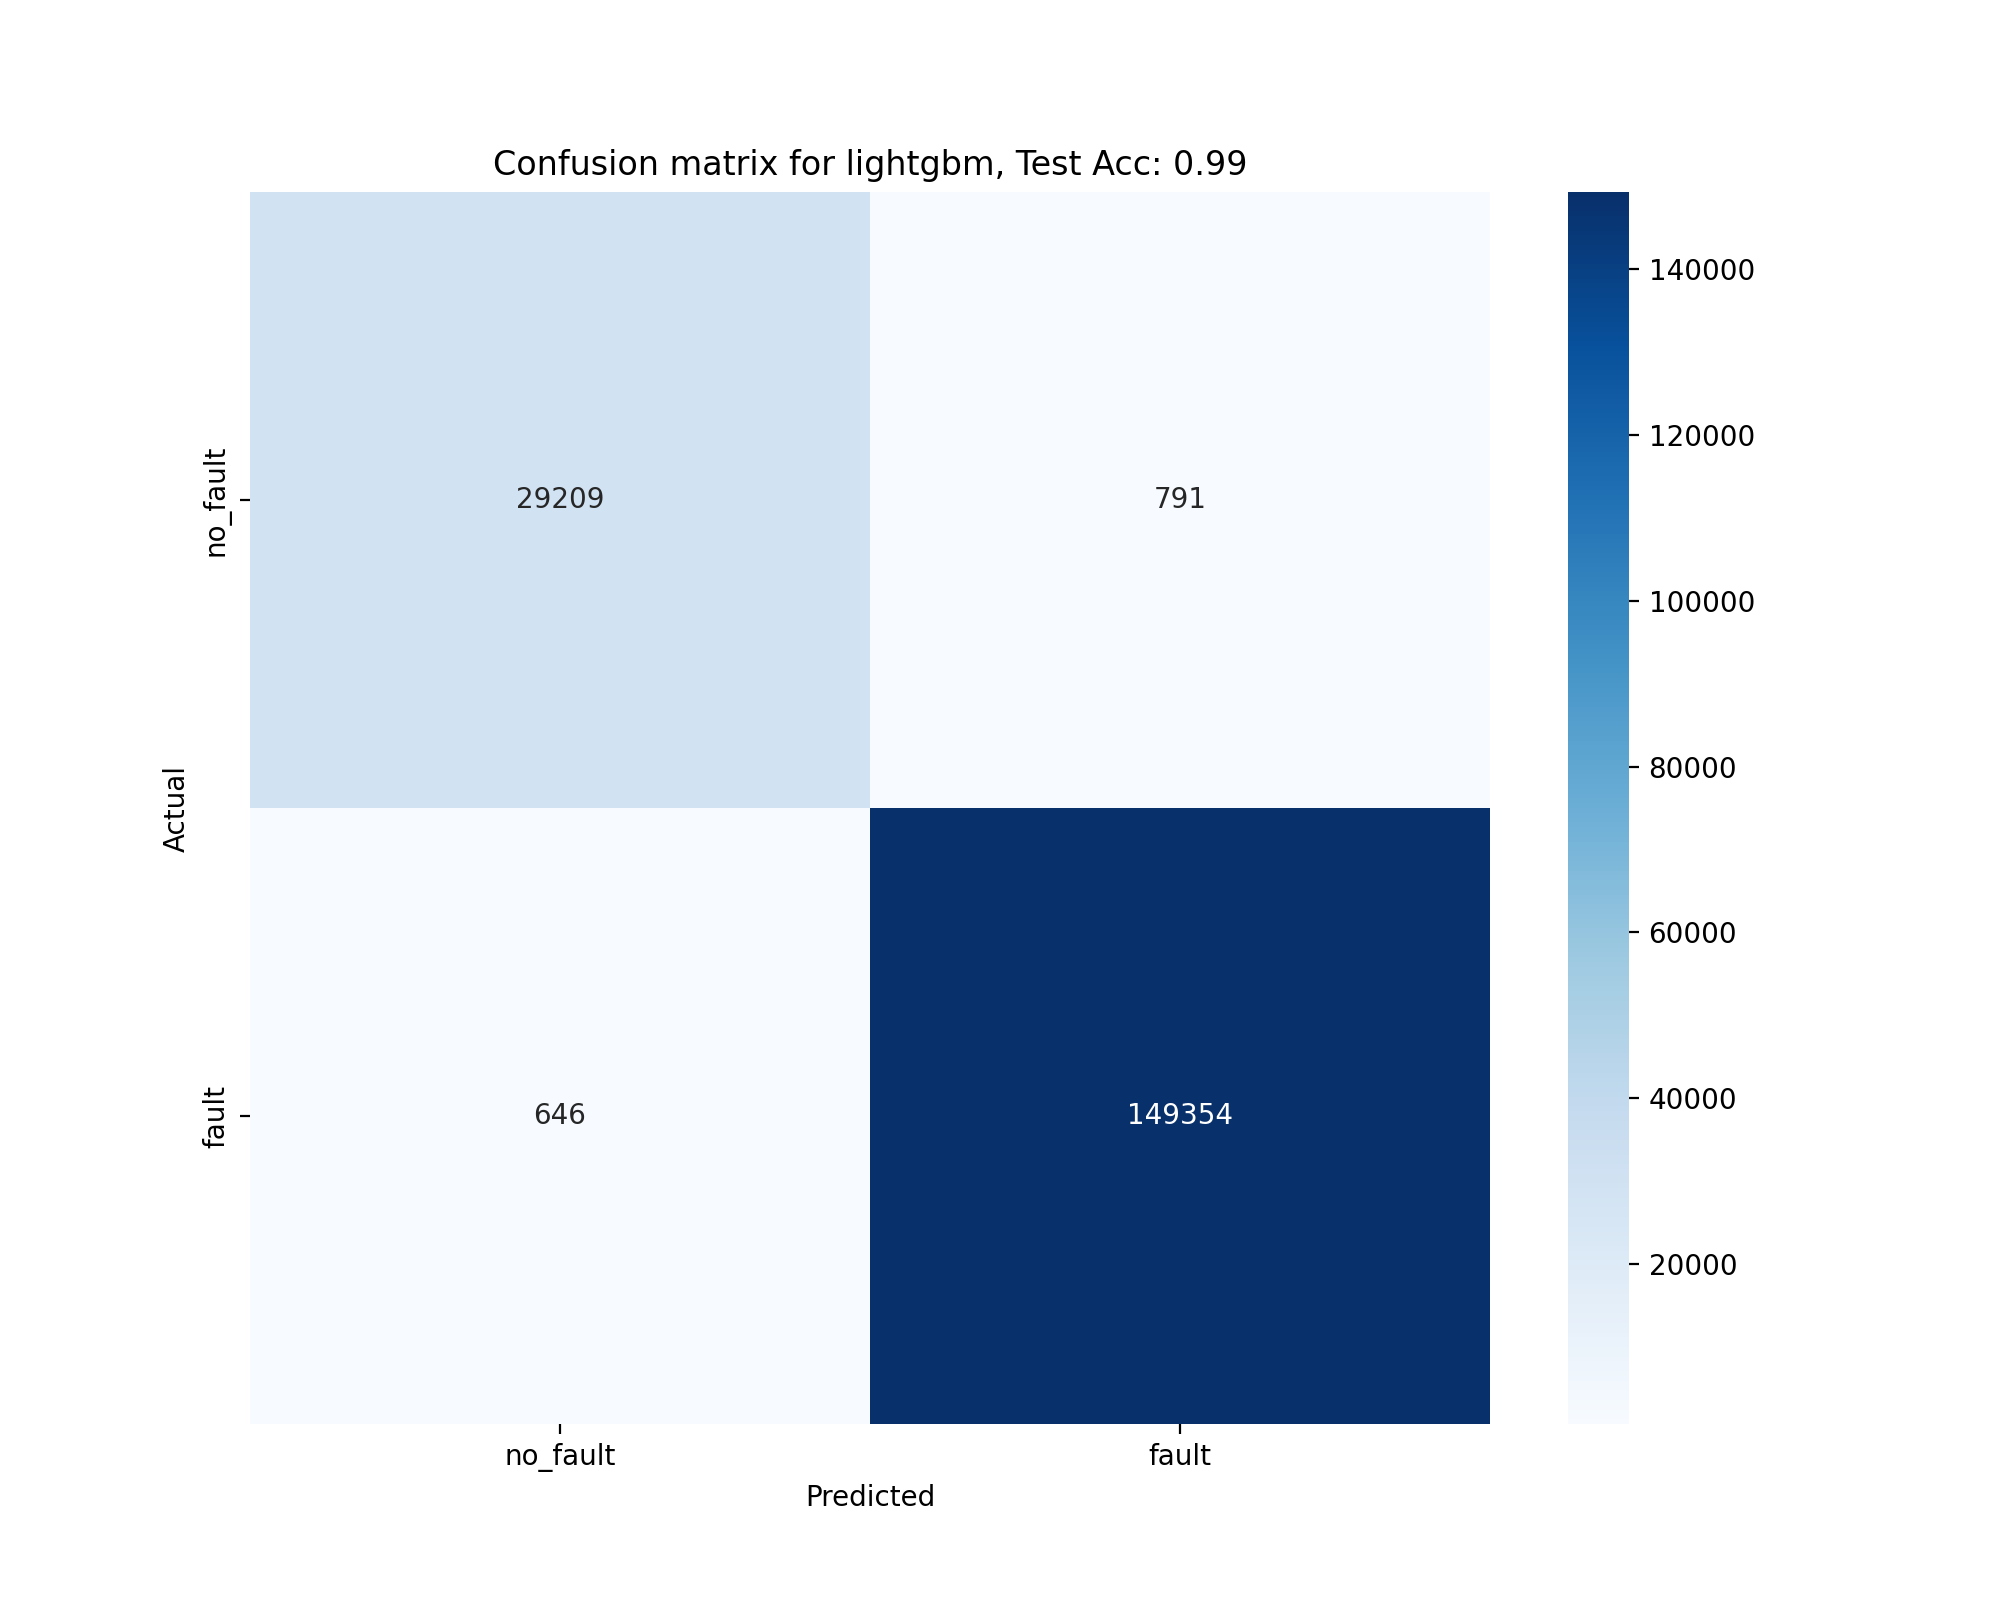

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


<Figure size 640x480 with 0 Axes>

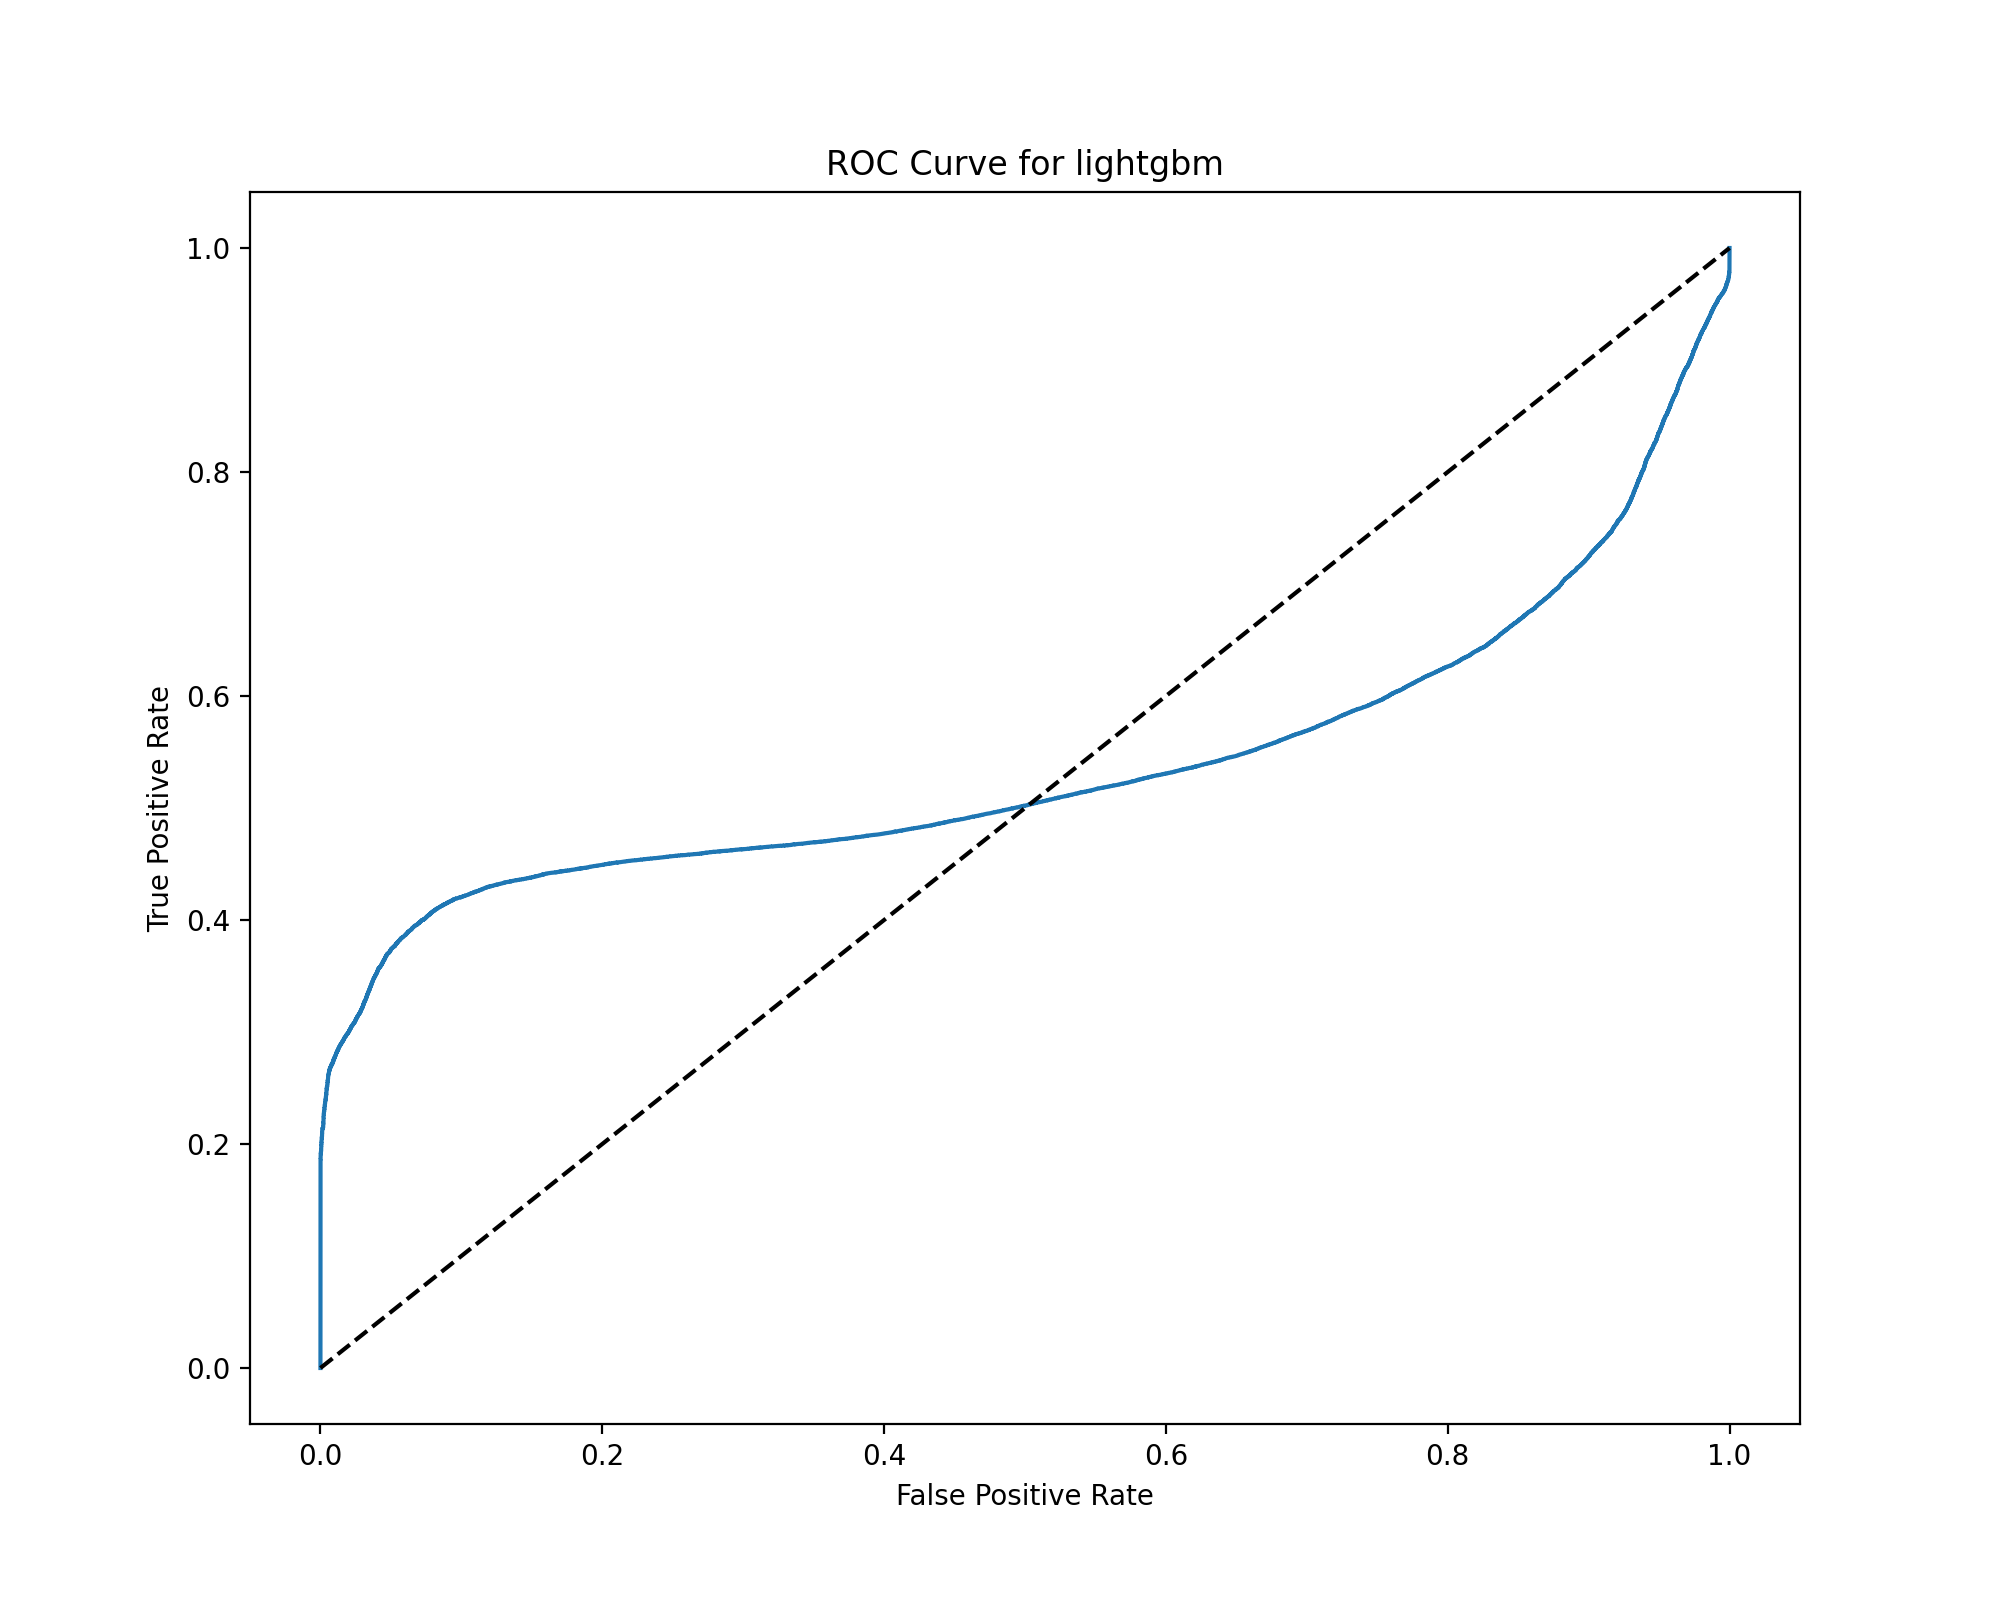

In [98]:
# Transform y_test arrays values where the number does not equals 0 to 1
y_tests = np.where(y_test != 0, 1, 0)
unique, counts = np.unique(y_tests, return_counts=True)

# Directory containing the models
model_directory = 'models'
models = os.listdir(model_directory)
model_accuracies = {}

for model in models:
    if model.endswith('.h5'):
        # Split the filename to isolate the parts
        parts = model.rsplit('_', 1)  # This splits only at the last underscore
        model_name = '_'.join(parts[:-1])  # Rejoin all but the last part for the full model name
        accuracy_part = parts[-1].replace('.h5', '')  # The last part, without '.h5'
        
        try:
            model_accuracy = float(accuracy_part)  # Convert the accuracy part to float
            model_accuracies[model_name] = model_accuracy  # Store using model name
        except ValueError:
            print(f"Could not convert {accuracy_part} to float for model {model}")

# Find the model with the highest accuracy
if model_accuracies:
    best_model_name, best_model_accuracy = max(model_accuracies.items(), key=lambda item: item[1])
    print(f'Best model: {best_model_name}, Validation Accuracy: {best_model_accuracy}')
else:
    print("No valid model accuracies found.")

# Predict with the best model and evaluate, plot the confusion matrix and the ROC curve
# Load the best model
best_model_path = f'models/{best_model_name}_{best_model_accuracy:.4f}.h5'
best_model = joblib.load(best_model_path)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Refit model on the full training data
best_model.fit(X_train, y_train)

# Predict the test set
y_preds = best_model.predict(X_test)
y_preds = np.where(y_preds != 0, 1, 0)

# Calculate the accuracy
accuracy = accuracy_score(y_tests, y_preds)
display(print(f'Accuracy: {accuracy:.4f}'))

# Calculate the confusion matrix
cm = confusion_matrix(y_tests, y_preds)

# Show confnusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_fault', 'fault'], yticklabels=['no_fault', 'fault'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion matrix for {best_model_name}, Test Acc: {accuracy:.2f}')
plt.show()
plt.savefig(f'plots/confusion_matrix_{best_model_name}_{best_model_accuracy:.4f}.png')
# Calculate the ROC curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_tests, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {best_model_name}')
plt.show()
plt.savefig(f'plots/roc_curve_{best_model_name}_{best_model_accuracy:.4f}.png')


In [99]:
# Print the classification report
print(classification_report(y_tests, y_preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     30000
           1       0.99      1.00      1.00    150000

    accuracy                           0.99    180000
   macro avg       0.99      0.98      0.99    180000
weighted avg       0.99      0.99      0.99    180000



In [100]:
# Print test times
print(f'Testing times: {test_times}')

Testing times: [4.707435369491577, 5.00362753868103, 0.04587697982788086, 0.19946670532226562]
train_times


In [101]:
# Print training times
print(f'Training times: {train_times}')

Training times: [236.05926489830017, 312.279522895813, 15.47059965133667, 976.408406496048]


In [161]:
df_edit['sensor1_25_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
df_edit['sensor2_25_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).max())
df_edit['sensor1_25_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
df_edit['sensor2_25_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).min())
df_edit['sensor1_25_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
df_edit['sensor2_25_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).mean())
df_edit['sensor1_25_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
df_edit['sensor2_25_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).std())
df_edit['sensor1_25_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=25, min_periods=1).median())
df_edit['sensor2_25_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=25, min_periods=1).median())

df_edit['sensor1_50_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
df_edit['sensor2_50_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).max())
df_edit['sensor1_50_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
df_edit['sensor2_50_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).min())
df_edit['sensor1_50_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
df_edit['sensor2_50_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).mean())
df_edit['sensor1_50_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
df_edit['sensor2_50_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).std())
df_edit['sensor1_50_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=50, min_periods=1).median())
df_edit['sensor2_50_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=50, min_periods=1).median())

df_edit['sensor1_100_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
df_edit['sensor2_100_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).max())
df_edit['sensor1_100_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
df_edit['sensor2_100_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).min())
df_edit['sensor1_100_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
df_edit['sensor2_100_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).mean())
df_edit['sensor1_100_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
df_edit['sensor2_100_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).std())
df_edit['sensor1_100_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=100, min_periods=1).median())
df_edit['sensor2_100_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=100, min_periods=1).median())

df_edit['sensor1_200_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
df_edit['sensor2_200_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).max())
df_edit['sensor1_200_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
df_edit['sensor2_200_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).min())
df_edit['sensor1_200_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
df_edit['sensor2_200_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
df_edit['sensor1_200_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
df_edit['sensor2_200_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).std())
df_edit['sensor1_200_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=200, min_periods=1).median())
df_edit['sensor2_200_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=200, min_periods=1).median())

df_edit['sensor1_400_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
df_edit['sensor2_400_max'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).max())
df_edit['sensor1_400_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
df_edit['sensor2_400_min'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).min())
df_edit['sensor1_400_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
df_edit['sensor2_400_mean'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).mean())
df_edit['sensor1_400_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
df_edit['sensor2_400_std'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).std())
df_edit['sensor1_400_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor1'].transform(lambda x: x.rolling(window=300, min_periods=1).median())
df_edit['sensor2_400_median'] = df_edit.groupby(['state_expected', 'load_value', 'speedSet'])['sensor2'].transform(lambda x: x.rolling(window=300, min_periods=1).median())

In [162]:
df_40_80 = df_edit[(df_edit.speedSet == 8.33203125) & (df_edit.load_value == 0)]
df_40_80 = df_40_80[(df_40_80.state_expected == 0) | (df_40_80.state_expected == 1)].copy()
df_40_80.sort_values(by = ['state_expected', 'time_normalized'], inplace = True)

In [163]:
df_40_80 = df_40_80.drop(columns=['time_normalized'])
df_40_80_y = df_40_80.state_expected
df_40_80_x = df_40_80.drop(columns=['state_expected'])

In [165]:
df_edit_y = df_edit.state_expected
df_edit_x = df_edit.drop(columns=['time_normalized', 'state_expected'])

# Standardize the data
df_40_80_x = scaler.fit_transform(df_40_80_x)
df_edit_x = scaler.fit_transform(df_edit_x)

# Refit model on the full training data
best_model.fit(df_edit_x, df_edit_y)

# Predict the test set
y_pred_8_0 = best_model.predict(df_40_80_x)
y_pred_8_0 = np.where(y_pred_8_0 != 0, 1, 0)

#best_case_predict = best_model.predict(df_40_80_x)

# Calculate the accuracy
accuracy = accuracy_score(df_40_80_y, y_pred_8_0)
display(print(f'Accuracy: {accuracy:.4f}'))

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 54
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -

None

In [168]:
print(df_40_80_y, y_pred_8_0)

0        0
1        0
2        0
3        0
4        0
        ..
24995    1
24996    1
24997    1
24998    1
24999    1
Name: state_expected, Length: 50000, dtype: int64 [1 1 1 ... 1 1 1]


c:\Users\rober\AppData\Local\Programs\Python\Python38\lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 2 rows containing missing values.


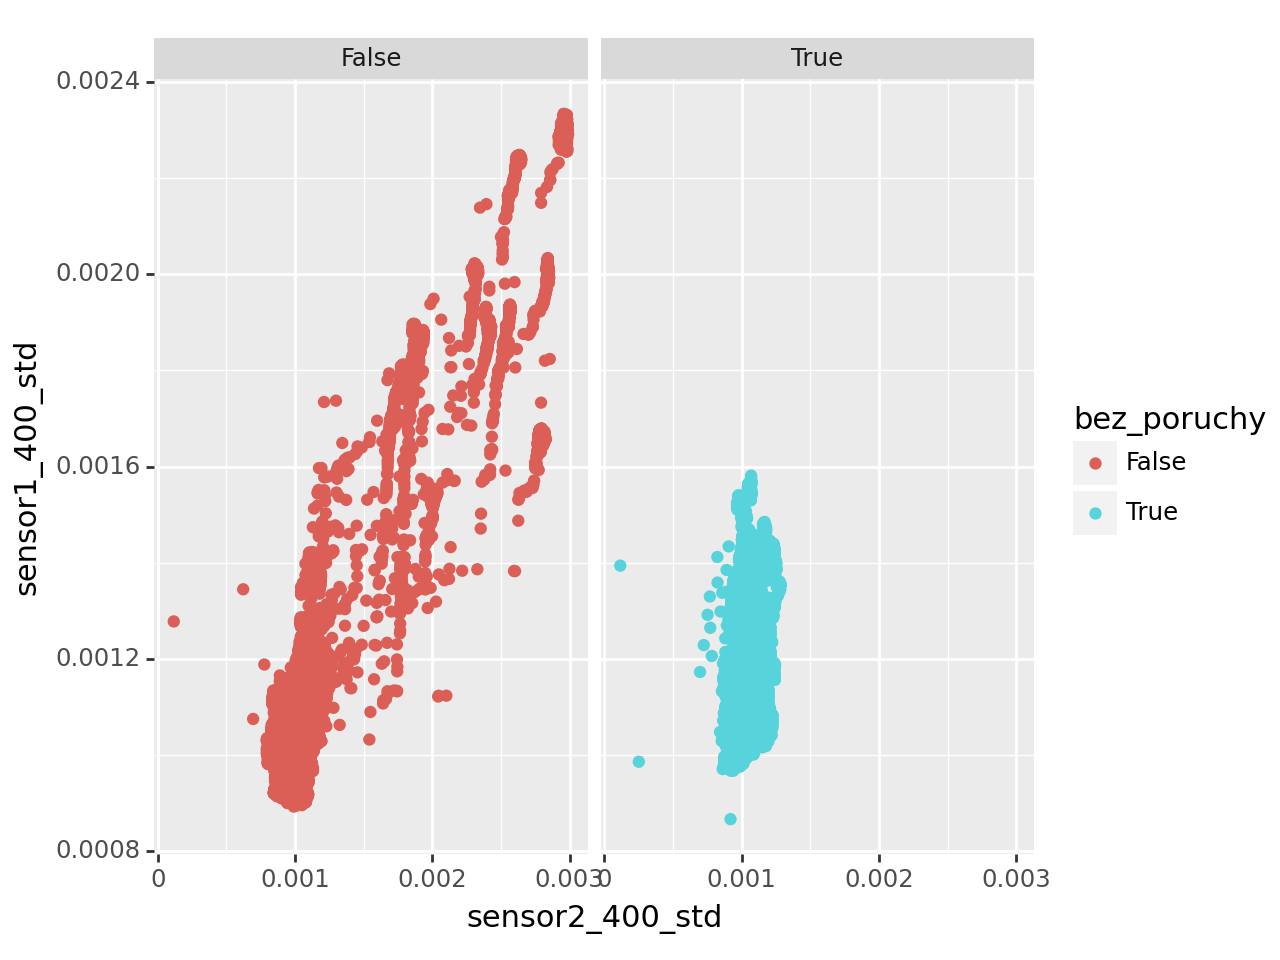

<Figure Size: (640 x 480)>

In [166]:
df_40_80.state_expected.astype(str).iloc[0]
df_40_80['bez_poruchy'] = df_40_80['state_expected'] == 0
display(ggplot(data=df_40_80,
               mapping=aes(x='sensor2_400_std', y='sensor1_400_std', color='bez_poruchy'))
        + geom_point()
        + facet_wrap('~bez_poruchy'))

In [167]:
df_25_80_y = df_40_80['state_expected']
df_25_80_x = df_40_80.drop(columns = ['state_expected', 'bez_poruchy'])


In [ ]:
"""
# Merge X_train_not_scaled and y_train
df_train = X_train_not_scaled.copy()
df_test = X_test_not_scaled.copy()
df_train['state_expected'] = y_train
df_test['state_expected'] = y_test
df_train.state_expected.astype(str).iloc[0]
df_train['bez_poruchy'] = df_train['state_expected'] == 0

plot = (ggplot(data=df_train[(df_train.speedSet == 8.33203125) & (df_train.load_value == 0)],
               mapping=aes(x='sensor2_400_std', y='sensor1_400_std', color='bez_poruchy'))
        + geom_point()
        + facet_wrap('~bez_poruchy'))

display(plot)
# Drop time normalized
df_train = df_train.drop(columns=['time_normalized'])
df_test = df_test.drop(columns=['time_normalized'])
df_train_8_80 = df_train[(df_train.speedSet == 8.33203125) & (df_train.load_value == 80)]
df_train_8_80 = df_train_8_80[(df_train_8_80.state_expected == 0) | (df_train_8_80.state_expected == 1)].copy()
df_train_8_80.sort_values(by = ['state_expected'], inplace = True)

df_test_8_80 = df_test[(df_test.speedSet == 8.33203125) & (df_test.load_value == 80)]
df_test_8_80 = df_test_8_80[(df_test_8_80.state_expected == 0) | (df_test_8_80.state_expected == 1)].copy()
df_test_8_80.sort_values(by = ['state_expected'], inplace = True)
df_train_8_80_y = df_train_8_80['state_expected']
df_test_8_80_y = df_test_8_80['state_expected']
df_train_8_80_x = df_train_8_80.drop(columns = ['state_expected', 'bez_poruchy'])
df_test_8_80_x = df_test_8_80.drop(columns = ['state_expected'])
# Standardize the data
scaler = StandardScaler()
df_train_8_80_x = scaler.fit_transform(df_train_8_80_x)
df_test_8_80_x = scaler.fit_transform(df_test_8_80_x)
#best_model.fit(df_train_8_80_x, df_train_8_80_y)
best_case_predict = best_model.predict(df_test_8_80_x)
# if best_case_predict is not 0 it is 1
best_case_predict = np.where(best_case_predict != 0, 1, 0)
best_case_accuracy = accuracy_score(df_test_8_80_y, best_case_predict)
display(print(f'Accuracy: {best_case_accuracy:.4f}'))
df_test_8_80['predicted'] = best_case_predict
df_test_8_80['indexer'] = df_test_8_80.reset_index(drop = True).index * 0.0002

df_test_8_80['good_prediction'] = df_test_8_80.predicted == df_test_8_80.state_expected

df_test_8_80.predicted.value_counts()

# make predicted2 column, whne predicted is > 0 then return 1
df_test_8_80['predicted2'] = np.where(df_test_8_80['predicted'] > 0, 1, 0)
df_test_8_80['good_prediction2'] = df_test_8_80.predicted2 == df_test_8_80.state_expected
df_test_8_80['good_prediction2'].value_counts()

# Usage
window_size = 500  # For example, check over 10 consecutive predictions
# Calculate the rolling average of predicted outcomes
rolling_avg = df_test_8_80['predicted2'].rolling(window=window_size).mean()

# Find the first index where the rolling average exceeds the threshold
first_above_threshold = rolling_avg > 95
if first_above_threshold.any():
    first_index = first_above_threshold.idxmax()
    df_test_8_80['indexer'][first_index]
else:
    None  # No point exceeds the threshold
threshold_point = df_train_8_80, window_size
if threshold_point is not None:
    print(f"Early stopping point at indexer: {threshold_point}")
else:
    print("No point exceeds the threshold within the given window.")

threshold_point = 1

display(ggplot(data = df_test_8_80, mapping = aes(x = 'indexer', y = 'predicted2', color = 'good_prediction2')) 
        + geom_point(alpha = 0.5) + geom_vline(aes(xintercept = threshold_point), color = 'red'))
"""

'\n# Merge X_train_not_scaled and y_train\ndf_train = X_train_not_scaled.copy()\ndf_test = X_test_not_scaled.copy()\ndf_train[\'state_expected\'] = y_train\ndf_test[\'state_expected\'] = y_test\ndf_train.state_expected.astype(str).iloc[0]\ndf_train[\'bez_poruchy\'] = df_train[\'state_expected\'] == 0\n\nplot = (ggplot(data=df_train[(df_train.speedSet == 8.33203125) & (df_train.load_value == 0)],\n               mapping=aes(x=\'sensor2_400_std\', y=\'sensor1_400_std\', color=\'bez_poruchy\'))\n        + geom_point()\n        + facet_wrap(\'~bez_poruchy\'))\n\ndisplay(plot)\n# Drop time normalized\ndf_train = df_train.drop(columns=[\'time_normalized\'])\ndf_test = df_test.drop(columns=[\'time_normalized\'])\ndf_train_8_80 = df_train[(df_train.speedSet == 8.33203125) & (df_train.load_value == 80)]\ndf_train_8_80 = df_train_8_80[(df_train_8_80.state_expected == 0) | (df_train_8_80.state_expected == 1)].copy()\ndf_train_8_80.sort_values(by = [\'state_expected\'], inplace = True)\n\ndf_test_